In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout
import tensorflow as tf
import random
from statsmodels.tsa.seasonal import STL
import os
SEED = 42
np.random.seed(SEED)
random.seed(SEED)
tf.random.set_seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)

## Load Data

In [2]:
df = pd.read_csv('/content/AP004.csv')

## Mari kita liat sekilas datanya, untuk melihat data ini tentang apa

In [3]:
df.head()


From Date              To Date  PM2.5 (ug/m3)  PM10 (ug/m3)  \
0  2017-09-05 14:00:00  2017-09-05 15:00:00          25.00         45.00   
1  2017-09-05 15:00:00  2017-09-05 16:00:00          23.00         49.50   
2  2017-09-05 16:00:00  2017-09-05 17:00:00          18.00         55.75   
3  2017-09-05 17:00:00  2017-09-05 18:00:00          19.75         33.50   
4  2017-09-05 18:00:00  2017-09-05 19:00:00          14.00         28.00   

   NO (ug/m3)  NO2 (ug/m3)  NOx (ppb)  NH3 (ug/m3)  SO2 (ug/m3)  CO (mg/m3)  \
0        1.80        12.20       7.90        10.20         5.60        0.35   
1        0.65        14.55       8.28         8.85         4.52        0.41   
2        4.00        26.58      17.40         6.23         5.35        0.38   
3        1.63        21.78      12.92         8.30         5.30        0.48   
4        1.07        26.38      14.90         3.42         4.68        0.43   

   ...  Temp (degree C)  RH (%)  WS (m/s)  WD (degree)  SR (W/mt2)  BP (mmHg)  \
0  ...            30.30   69.00      3.20       213.00      372.00     747.00   
1  ...            30.00   70.50      4.10       140.00      290.75     747.25   
2  ...            29.85   88.00      2.82       174.75      300.25     747.00   
3  ...            29.25   88.75      1.72       231.50      225.50     747.75   
4  ...            28.05   88.50      1.97       105.25       11.25     748.25   

   VWS (m/s)  AT (degree C)  RF (mm)  Xylene (ug/m3)  
0       0.10          33.80     0.00            0.50  
1       0.05          32.22     0.00            0.48  
2       0.00          28.30     0.93            0.53  
3       0.00          28.77     0.00            1.85  
4       0.00          28.25     0.00            2.17  

[5 rows x 25 columns]

**Dataset ini adalah data kualitas udara multivariat yang direkam setiap jam** di sebuah stasiun pengamatan.  
Setiap baris berisi hasil pengukuran konsentrasi polutan udara (seperti PM2.5, PM10, NO2, CO, SO2), suhu udara (**Temp (degree C)**), kelembapan relatif (**RH**), kecepatan angin (**WS**), dan waktu pengukuran (**From Date**).
Karena seluruh pengamatan dicatat secara berkala sebagai **time series multivariat**, dataset ini sangat cocok digunakan untuk modeling **prediksi deret waktu (forecasting)** dengan pendekatan **RNN/LSTM**.  Nantinya, kita akan memanfaatkan data historis dari beberapa jam sebelumnya sebagai input untuk memprediksi nilai suhu udara dan parameter kualitas udara di jam berikutnya, sehingga model dapat menangkap *pola*, *trend*, serta *dinamika perubahan polutan dan cuaca* secara komprehensif.


# A

# EDA

In [4]:
print("\nInfo:")
print(df.info())



Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48802 entries, 0 to 48801
Data columns (total 25 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   From Date            48802 non-null  object 
 1   To Date              48802 non-null  object 
 2   PM2.5 (ug/m3)        46344 non-null  float64
 3   PM10 (ug/m3)         46917 non-null  float64
 4   NO (ug/m3)           47244 non-null  float64
 5   NO2 (ug/m3)          47224 non-null  float64
 6   NOx (ppb)            46628 non-null  float64
 7   NH3 (ug/m3)          47140 non-null  float64
 8   SO2 (ug/m3)          46649 non-null  float64
 9   CO (mg/m3)           46387 non-null  float64
 10  Ozone (ug/m3)        47156 non-null  float64
 11  Benzene (ug/m3)      46914 non-null  float64
 12  Toluene (ug/m3)      46908 non-null  float64
 13  Eth-Benzene (ug/m3)  23988 non-null  float64
 14  MP-Xylene (ug/m3)    39256 non-null  float64
 15  Temp (degree C)      21599 no

Dataset ini memiliki **48.802 baris** dan **25 kolom**, setiap kolom berisi pengukuran konsentrasi berbagai polutan udara (seperti **PM2.5**, **PM10**, **NO2**, **CO**, **SO2**, dll), suhu udara (**Temp (degree C)**, **AT (degree C)**), kelembapan relatif (**RH (%)**), kecepatan angin (**WS (m/s)**), dan waktu pengukuran (**From Date**). Sebagian besar kolom bertipe data numerik (`float64`), sedangkan dua kolom waktu (**From Date** dan **To Date**) bertipe objek (`object`).  Namun, terdapat perbedaan jumlah data **non-null** antar kolom, menandakan adanya **missing value** di sebagian fitur—misalnya, kolom **Temp (degree C)** dan **Eth-Benzene (ug/m3)** memiliki jumlah data yang jauh lebih sedikit dibandingkan total baris, menunjukkan sekilas >50% data kosong di kolom tersebut sehingga aku melakukan **pembersihan data (data cleaning)** dan **imputasi** agar model prediksi nantinya tidak terganggu oleh missing value.

## Shape Sebelum Pembersihan

In [5]:
print("\nShape:", df.shape)



Shape: (48802, 25)


Sebelum dilakukan penanganan missing value, dataset terdiri dari 48.802 baris dan 25 kolom.


 ## Urutan data by time

In [6]:
df = df.sort_values('From Date')

Sortir dataframe berdasarkan kolom From Date untuk menjamin urutan kronologis berbasis waktu

## Drop rows where target AT is missing

In [7]:
df = df.dropna(subset=['AT (degree C)'])

**Menghapus baris yang memiliki nilai target kosong** pada kolom `AT (degree C)`. Hal ini penting dilakukan karena model machine learning tidak dapat dilatih menggunakan baris tanpa target.

## Interpolasi time series pada seluruh fitur numerik

In [8]:
num_cols = df.select_dtypes(include='float64').columns
df[num_cols] = df[num_cols].interpolate(method='linear')

Mengisi missing value pada fitur numerik dengan interpolasi linear dengan tujuan menjaga kontinuitas dan pola data.

 ## Forward fill dan backward fill untuk sisa missing

In [9]:
df = df.fillna(method='ffill').fillna(method='bfill')

/tmp/ipython-input-9-1282391985.py:1: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill').fillna(method='bfill')


Jika masih ada missing value setelah interpolasi, lakukan pengisian dengan nilai sebelumnya (forward fill) atau setelahnya (backward fill), memastikan tidak ada missing value tersisa.

In [51]:
df.duplicated().sum()

np.int64(0)

Tidak ada data duplikat di dataset ini

## Drop kolom dengan missing value sangat banyak

In [10]:
missing_ratio = df.isnull().mean()
drop_cols = missing_ratio[missing_ratio > 0.8].index
df = df.drop(columns=drop_cols)


Selanjutnya, aku menghapus kolom yang memiliki proporsi missing value sangat tinggi (diatas 80%).  Kolom dengan missing value lebih dari 80% biasanya **tidak informatif** dan sulit untuk diimputasi, sehingga sebaiknya dibuang agar tidak mengganggu proses analisis dan modeling.


## Shape setelah pembersihan

In [11]:
print(df.info())
print("Shape setelah pembersihan:", df.shape)

<class 'pandas.core.frame.DataFrame'>
Index: 47286 entries, 0 to 48801
Data columns (total 25 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   From Date            47286 non-null  object 
 1   To Date              47286 non-null  object 
 2   PM2.5 (ug/m3)        47286 non-null  float64
 3   PM10 (ug/m3)         47286 non-null  float64
 4   NO (ug/m3)           47286 non-null  float64
 5   NO2 (ug/m3)          47286 non-null  float64
 6   NOx (ppb)            47286 non-null  float64
 7   NH3 (ug/m3)          47286 non-null  float64
 8   SO2 (ug/m3)          47286 non-null  float64
 9   CO (mg/m3)           47286 non-null  float64
 10  Ozone (ug/m3)        47286 non-null  float64
 11  Benzene (ug/m3)      47286 non-null  float64
 12  Toluene (ug/m3)      47286 non-null  float64
 13  Eth-Benzene (ug/m3)  47286 non-null  float64
 14  MP-Xylene (ug/m3)    47286 non-null  float64
 15  Temp (degree C)      47286 non-null  floa

Setelah dilakukan penanganan missing value, dataset terdiri dari 47.286 baris dan 25 kolom.


## Visualisasi Before and After Cleaning

In [12]:
df_before = df.copy() # simpan sebelum interpolasi/fillna

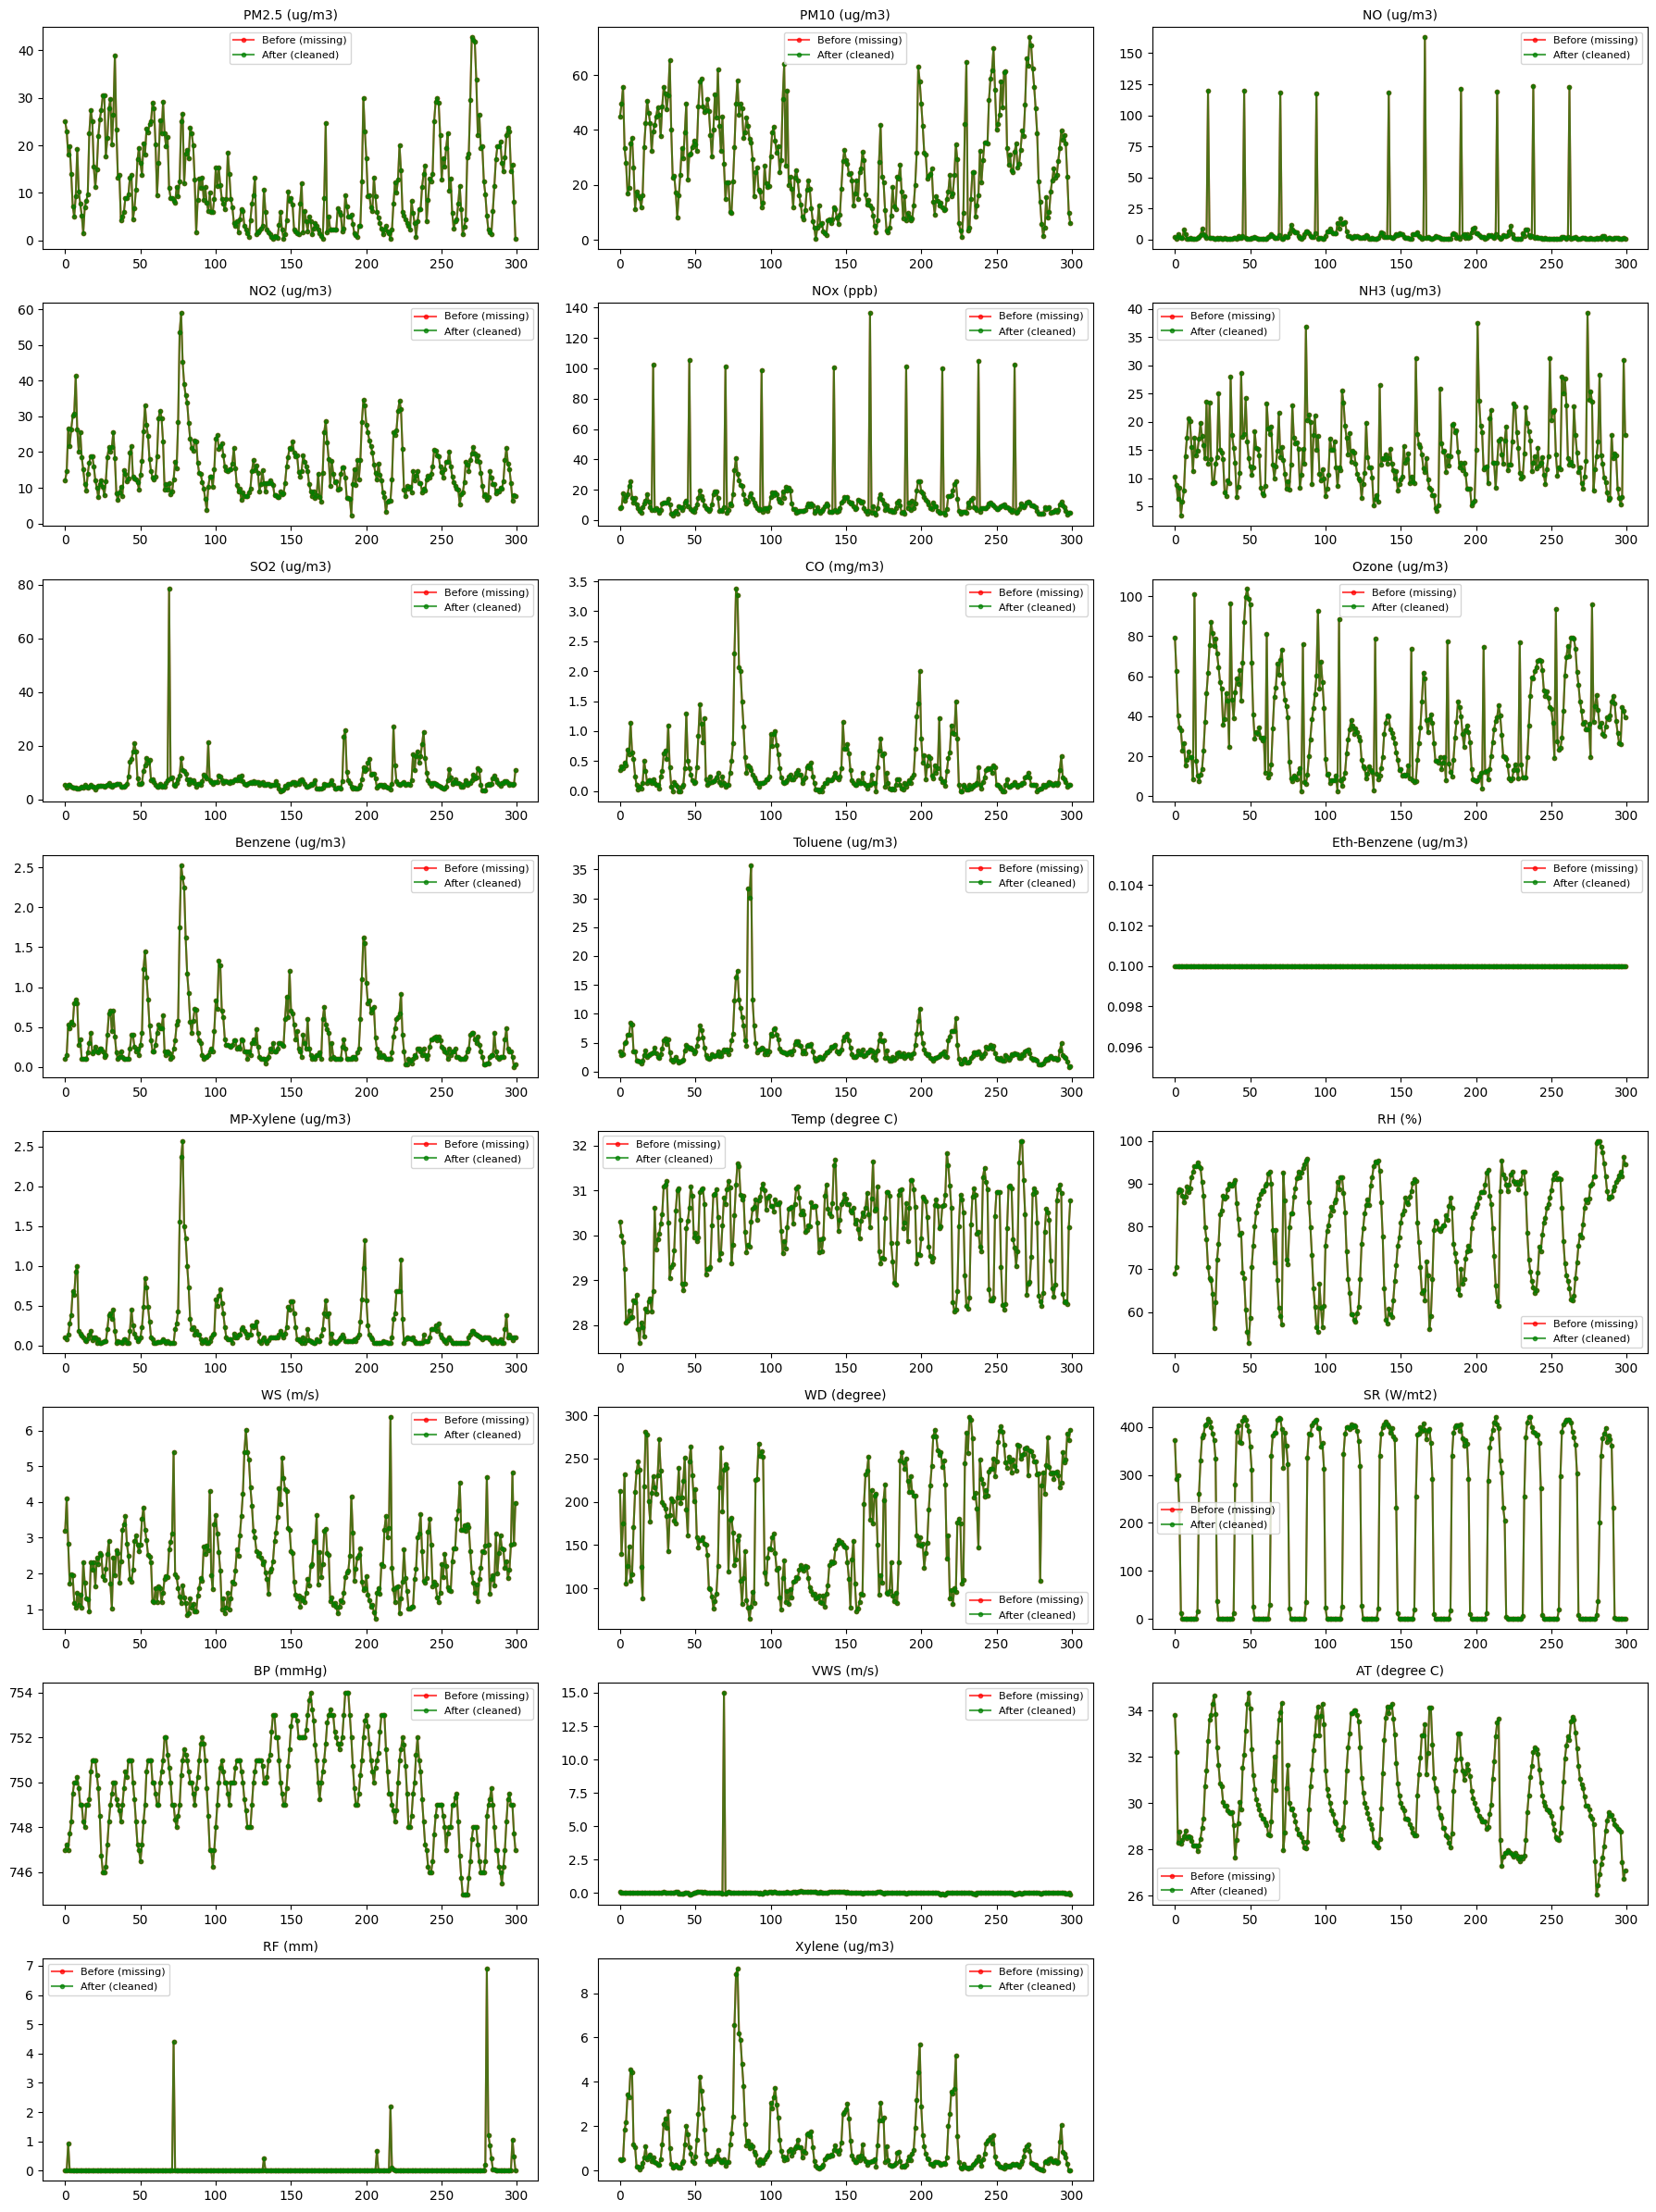

In [13]:
num_cols = [col for col in df.columns if df[col].dtype in ['float64', 'int64']]
n_cols = 3
n_rows = int(len(num_cols) / n_cols) + 1

plt.figure(figsize=(n_cols * 6, n_rows * 3))
sample_len = 300  # Banyak data pertama yang diplot

for i, col in enumerate(num_cols):
    plt.subplot(n_rows, n_cols, i+1)
    plt.plot(df_before[col].iloc[:sample_len], marker='.', linestyle='-', alpha=0.7, label='Before (missing)', color='red')
    plt.plot(df[col].iloc[:sample_len], marker='.', linestyle='-', alpha=0.7, label='After (cleaned)', color='green')
    plt.title(col, fontsize=10)
    plt.legend(fontsize=8)

plt.tight_layout()
plt.show()


Setelah proses interpolasi dan filling, data missing berhasil terisi dan pola time series tiap fitur tetap terjaga, hampir semua fitur yang tadinya memiliki gap(nampak sebagai loncatan/putus pada garis merah) kini terhubung rapih (hijau). Tidk terdapat distorsi ekstrem atau perubahan pola yang tidak wajar akibat proses imputasi.Proses cleaning dan imputasi sudah berjalan baik, tidak mengubah pola utama data

## Plot Distribusi Target (AT)

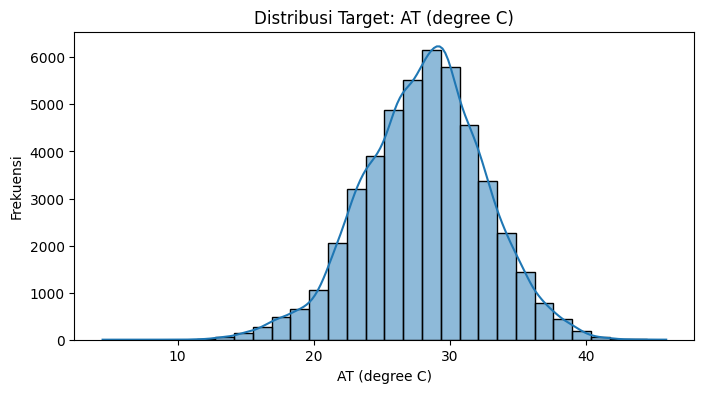

In [15]:
plt.figure(figsize=(8,4))
sns.histplot(df['AT (degree C)'], kde=True, bins=30)
plt.title('Distribusi Target: AT (degree C)')
plt.xlabel('AT (degree C)')
plt.ylabel('Frekuensi')
plt.show()

Distribusi suhu udara rata-rata (AT) membentuk pola hampir normal (bell-shaped) dengan puncak di sekitar 28–30°C.

## Plot Distribusi Semua Kolom Numerik

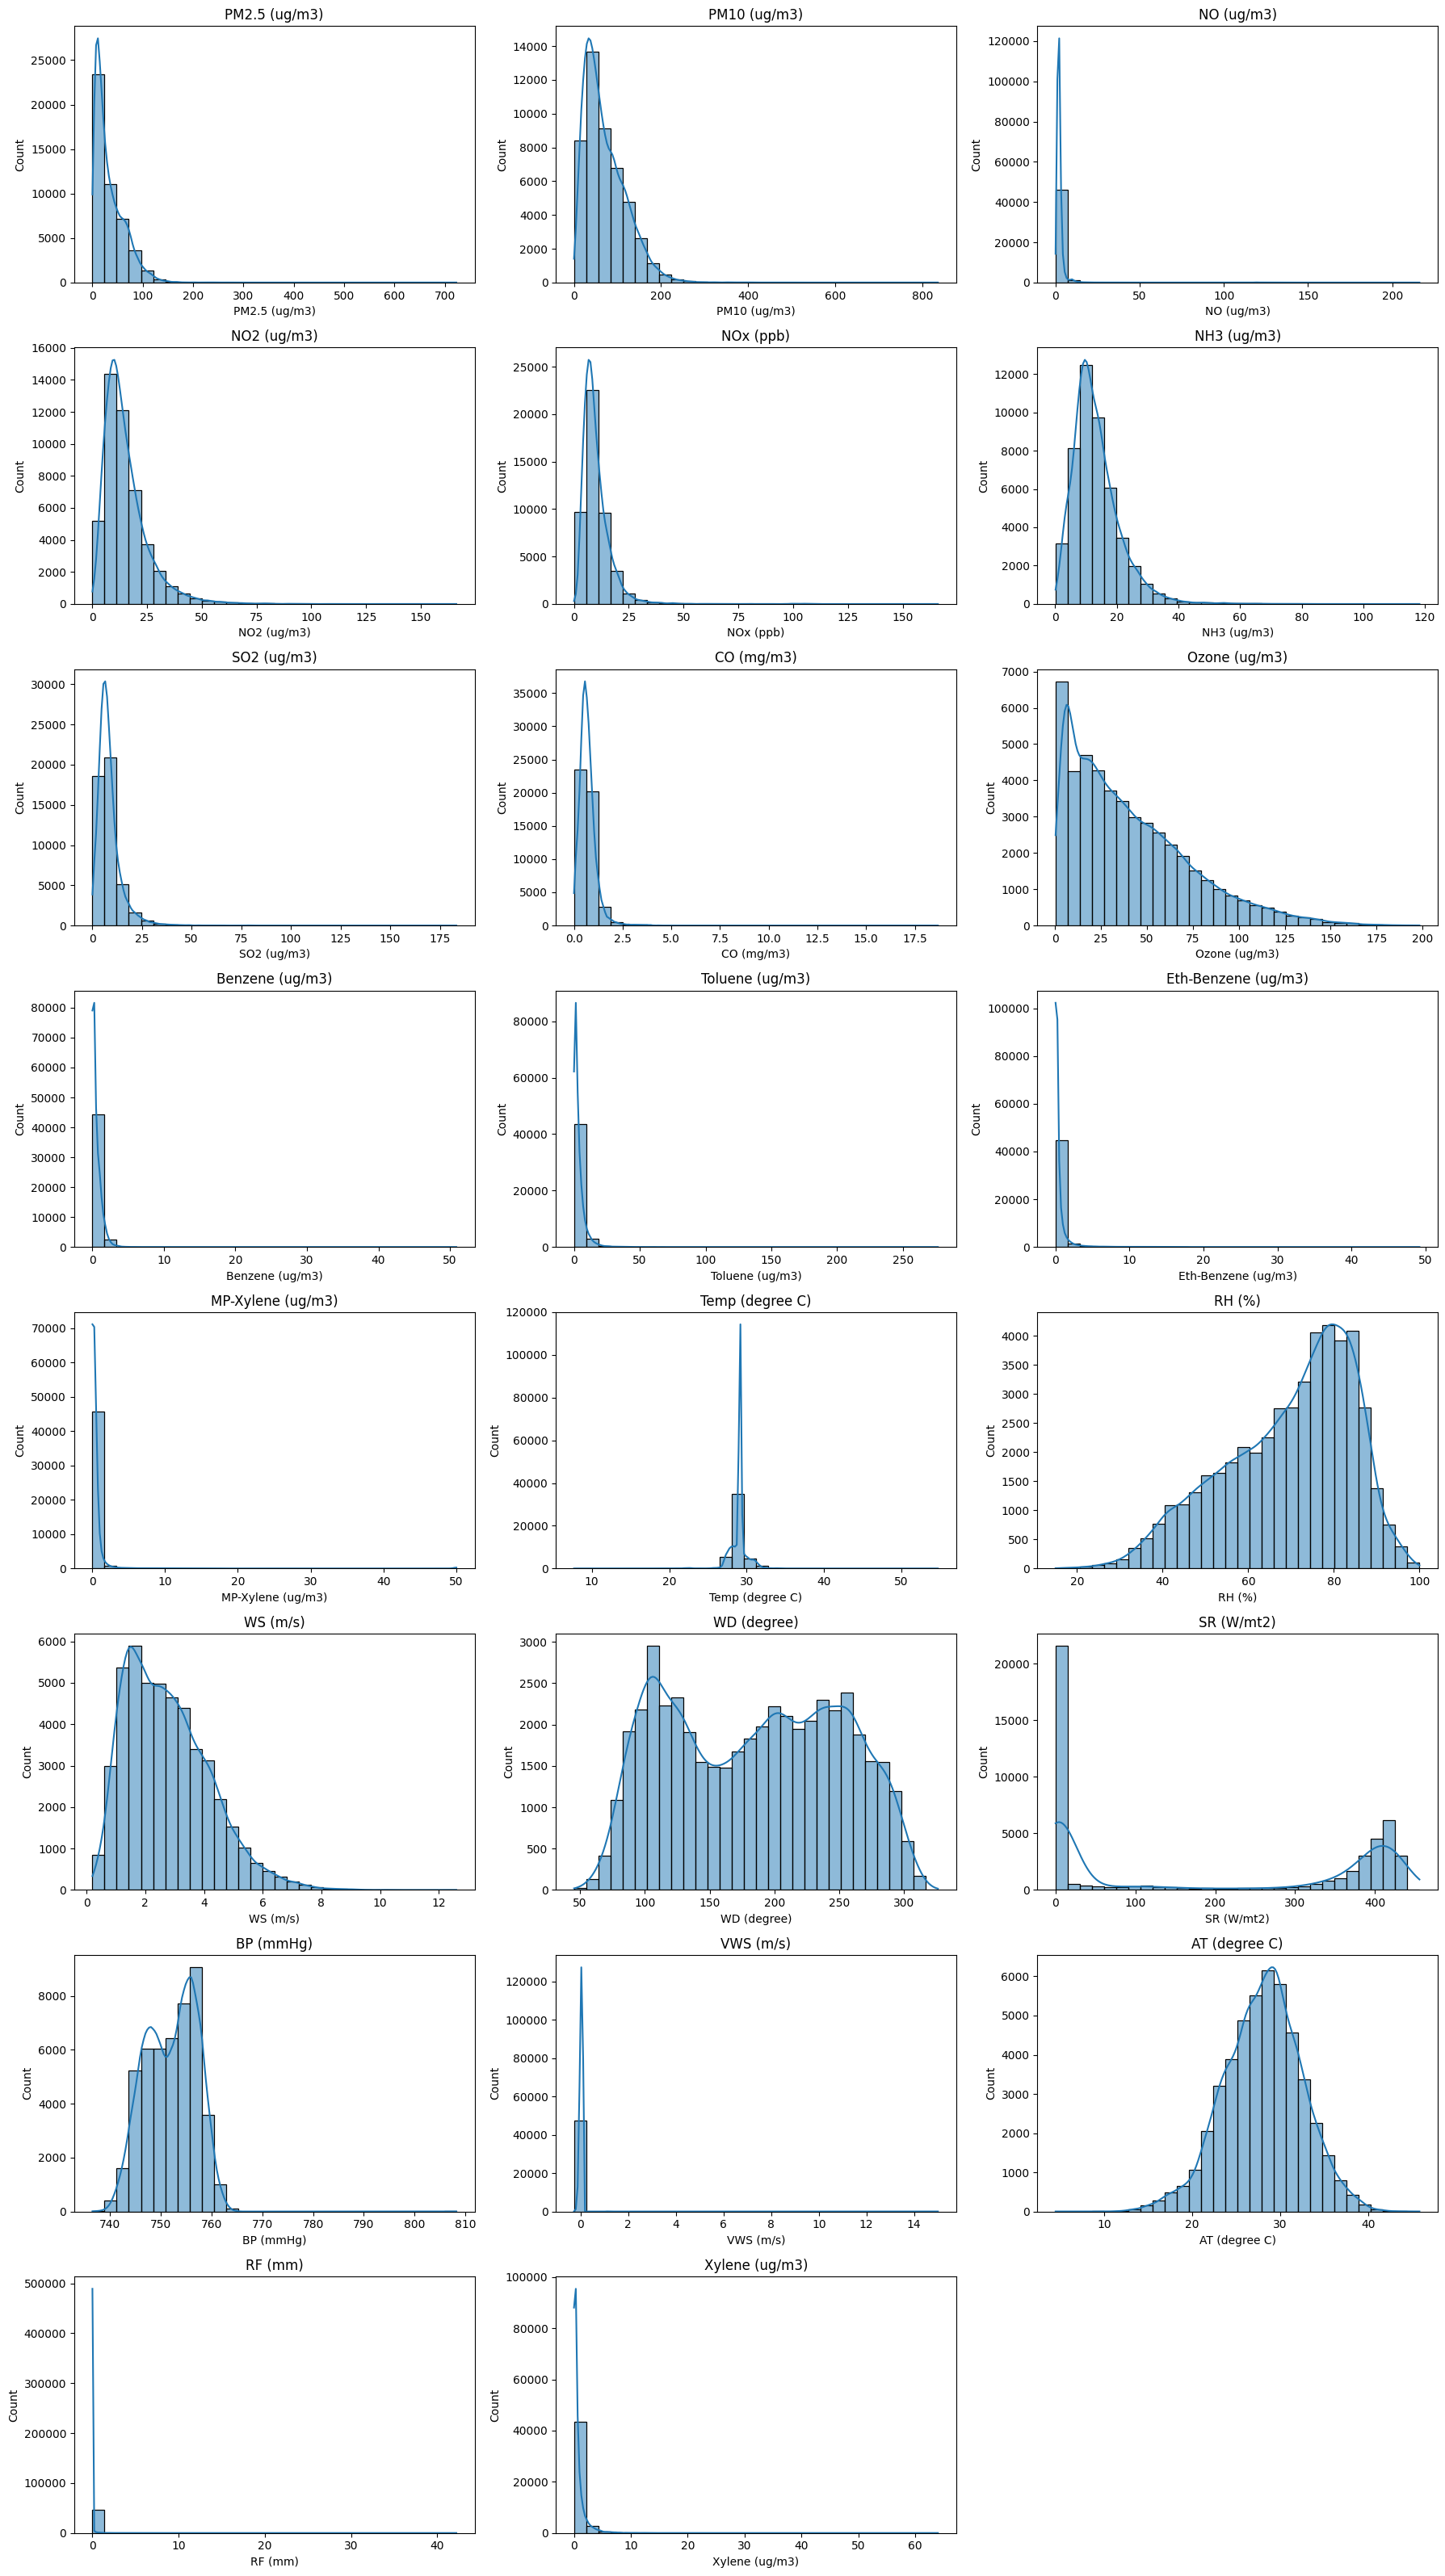

In [16]:
num_cols = [col for col in df.columns if df[col].dtype in ['float64', 'int64']]

n_cols = 3
n_rows = int(len(num_cols) / n_cols) + 1

plt.figure(figsize=(n_cols * 6, n_rows * 4))
for i, col in enumerate(num_cols):
    plt.subplot(n_rows, n_cols, i+1)
    sns.histplot(df[col], kde=True, bins=30)
    plt.title(col)
plt.tight_layout()
plt.show()


Mayoritas fitur polutan udara (PM2.5, PM10, NO, NO2, NOx, NH3, SO2, CO, Ozone, Benzene, Toluene, Eth-Benzene, MP-Xylene, Xylene, RF, VWS) distribusinya sangat skewed ke kanan (right-skewed/positif). Sebagian besar nilai rendah, sedikit nilai ekstrem (outlier tinggi).  Fitur suhu dan kelembapan (Temp (degree C), AT (degree C), RH (%)) tampak simetris/normal (seperti distribusi Gaussian).


Sebagian besar polutan dan variabel lingkungan memiliki distribusi skewed dan outlier tinggi. Oleh karena itu aku melekakukan log & capping outlier sebelum masuk ke model nantinya, aku akan cek tapi lebih dulu dengn boxlot

## Cek Out;ier Semua Kolom Numerik (Termasuk Target)

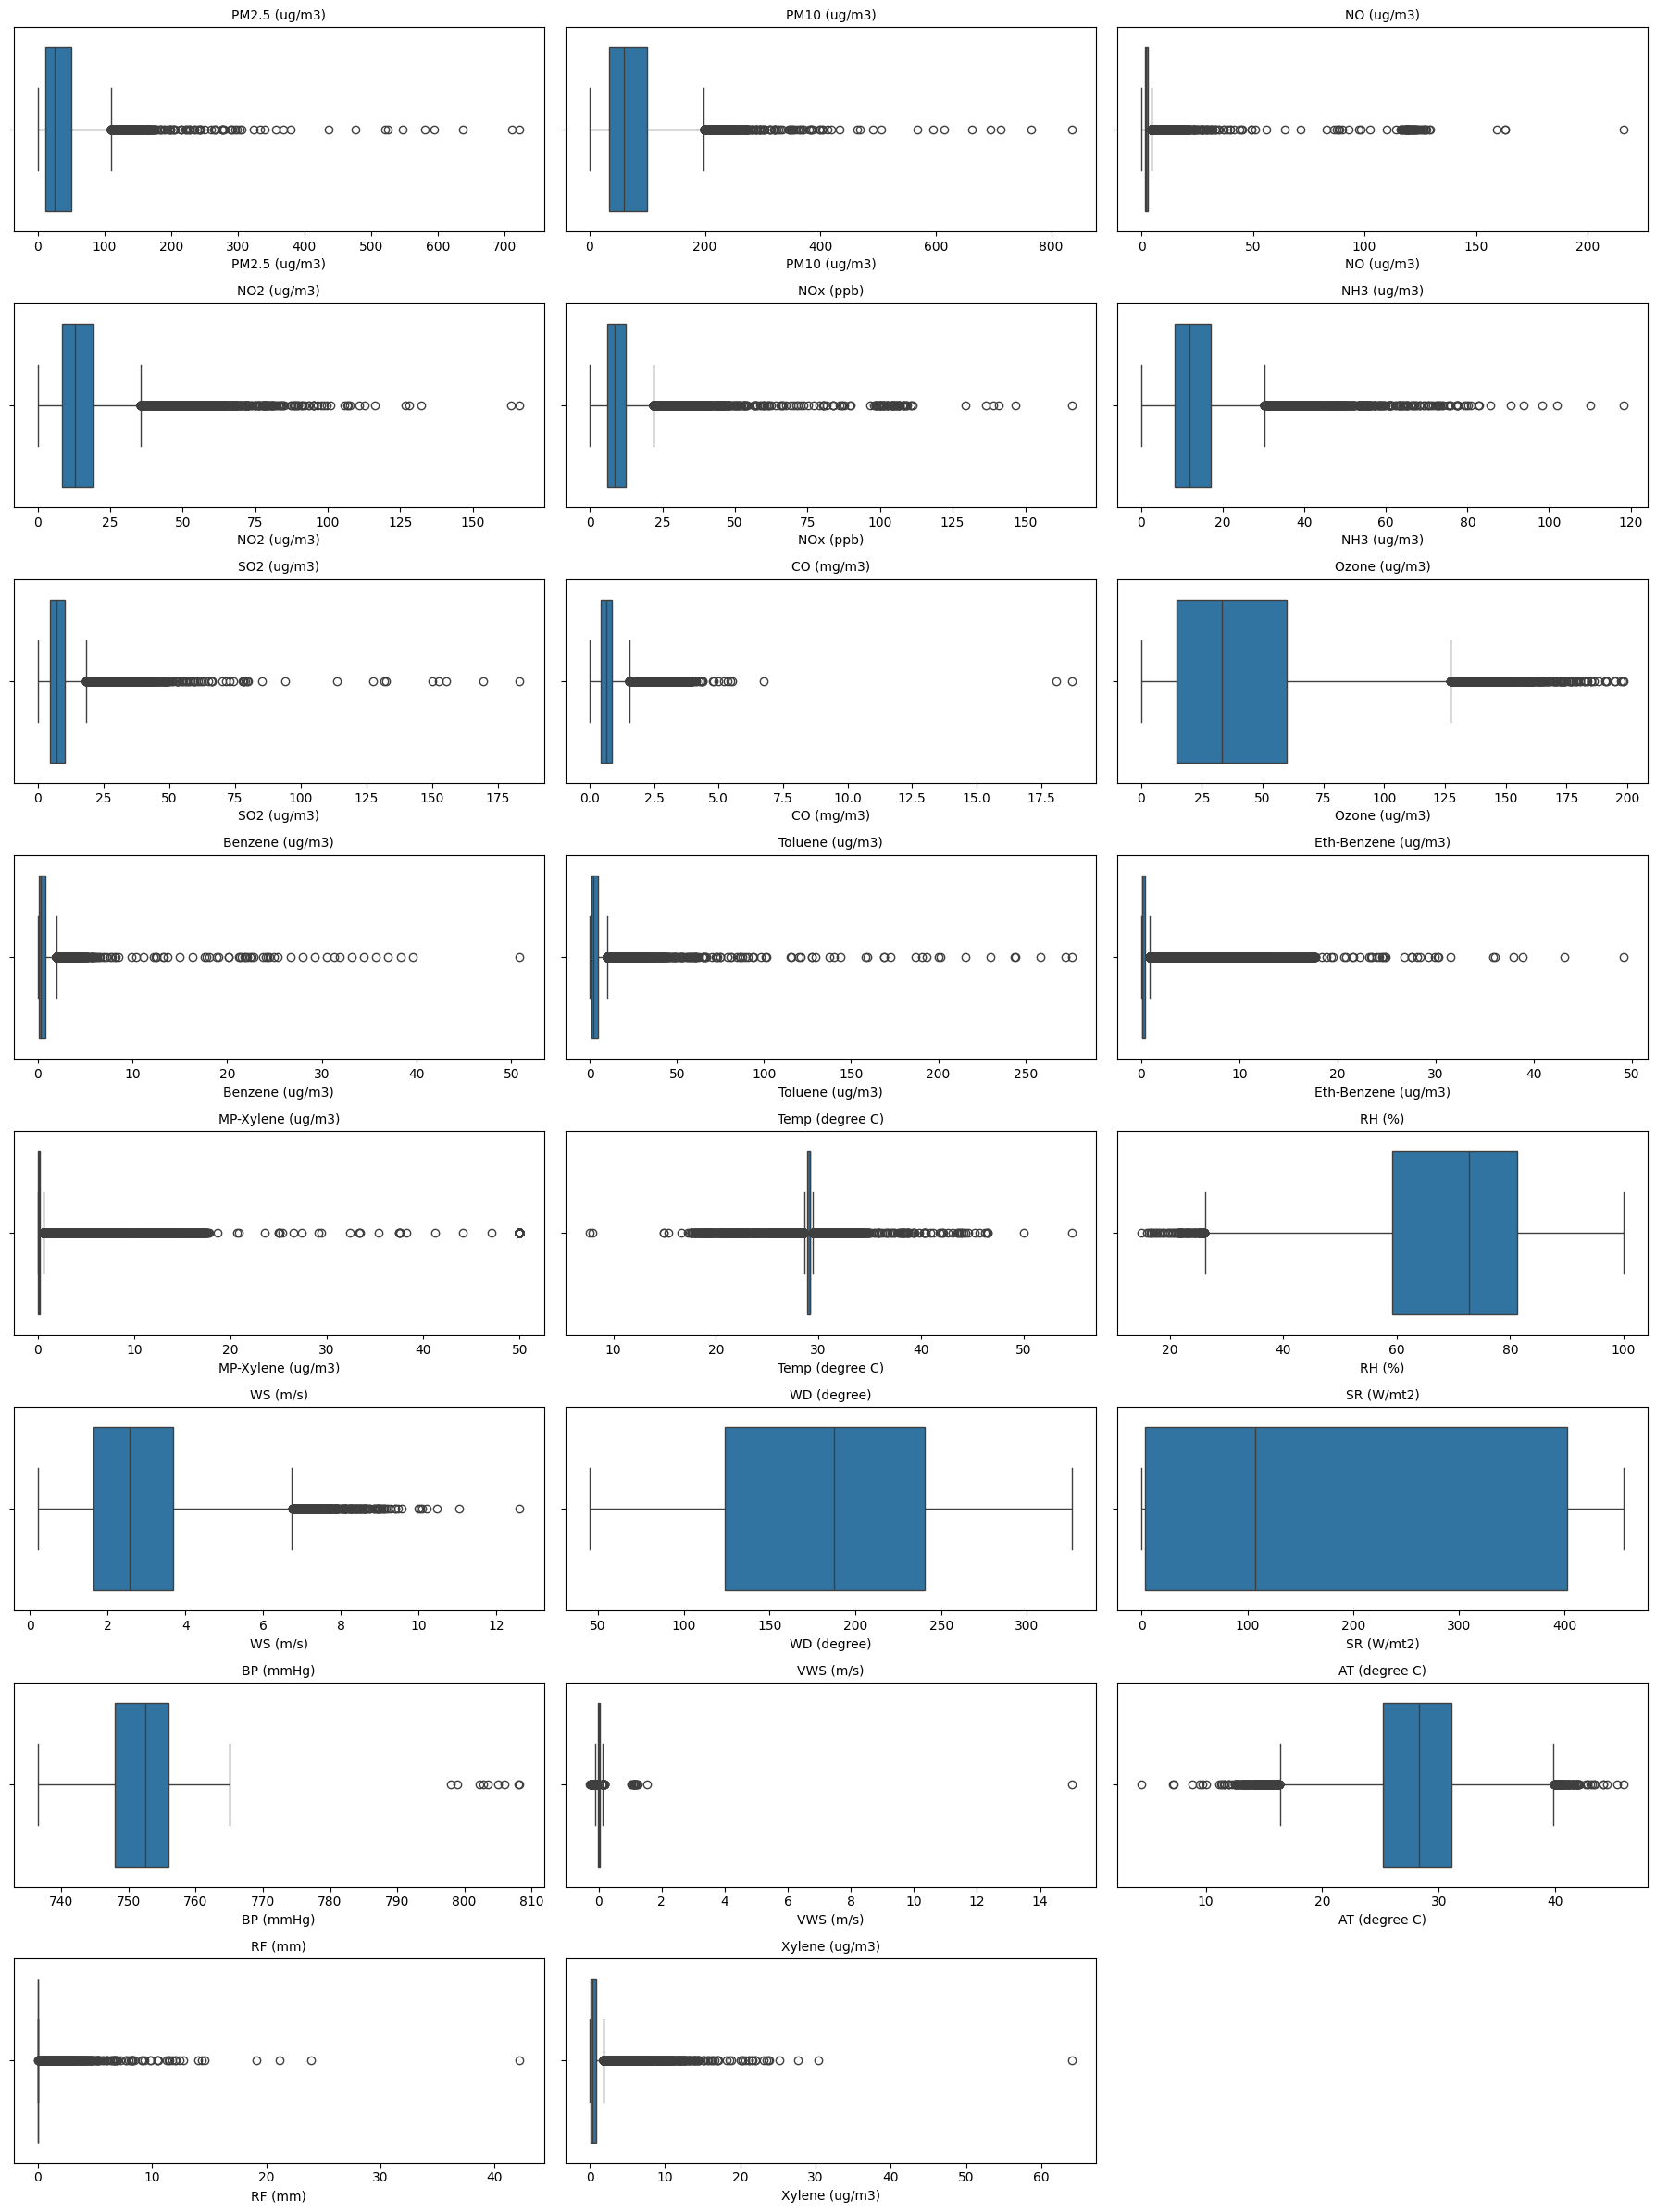

In [17]:
n_cols = 3
n_rows = int(len(num_cols) / n_cols) + 1

plt.figure(figsize=(n_cols * 6, n_rows * 3))
for i, col in enumerate(num_cols):
    plt.subplot(n_rows, n_cols, i+1)
    sns.boxplot(x=df[col])
    plt.title(col, fontsize=10)
plt.tight_layout()
plt.show()


### Deteksi Outlier dengan Boxplot untuk Seluruh Fitur Numerik
- Hampir semua fitur polutan udara (misal PM2.5, PM10, NOx, SO2, Benzene, dll) memperlihatkan banyak outlier di sisi kanan (nilai tinggi).
- Fitur cuaca seperti **AT (degree C)** (suhu udara), **RH (%)** (kelembapan), dan **BP (mmHg)** (tekanan udara) relatif lebih stabil dan simetris, meskipun ada beberapa outlier.
- Fitur seperti **SR (W/mt2)** (radiasi matahari) dan **WD (degree)** (arah angin) punya rentang variasi yang lebar, namun tidak terlalu banyak outlier.

Berarti dix karena hampir semua fitur polutan dan cuaca memiliki outlier tinggi, perlu capping (pembatasan outlier) dan/atau transformasi log sebelum digunakan sebagai input model.

## Feature engineering (log1p + capping outlier pada polutan)

In [18]:
skewed_cols = [
    'PM2.5 (ug/m3)', 'PM10 (ug/m3)', 'NO (ug/m3)', 'NO2 (ug/m3)', 'NOx (ppb)', 'NH3 (ug/m3)',
    'SO2 (ug/m3)', 'CO (mg/m3)', 'Ozone (ug/m3)', 'Benzene (ug/m3)', 'Toluene (ug/m3)',
    'Eth-Benzene (ug/m3)', 'MP-Xylene (ug/m3)', 'RF (mm)', 'Xylene (ug/m3)', 'VWS (m/s)'
]
for col in skewed_cols:
    df[col] = np.log1p(df[col])

In [19]:
capping_cols = [
    'PM2.5 (ug/m3)', 'PM10 (ug/m3)', 'NO (ug/m3)', 'NO2 (ug/m3)', 'NOx (ppb)', 'NH3 (ug/m3)',
    'SO2 (ug/m3)', 'CO (mg/m3)', 'Ozone (ug/m3)', 'Benzene (ug/m3)', 'Toluene (ug/m3)',
    'Eth-Benzene (ug/m3)', 'MP-Xylene (ug/m3)', 'RF (mm)', 'Xylene (ug/m3)', 'VWS (m/s)'
]

for col in capping_cols:
    upper = df[col].quantile(0.99)  # Ambil nilai 99th percentile
    df[col] = df[col].clip(upper=upper)

## Distribusi After Capping

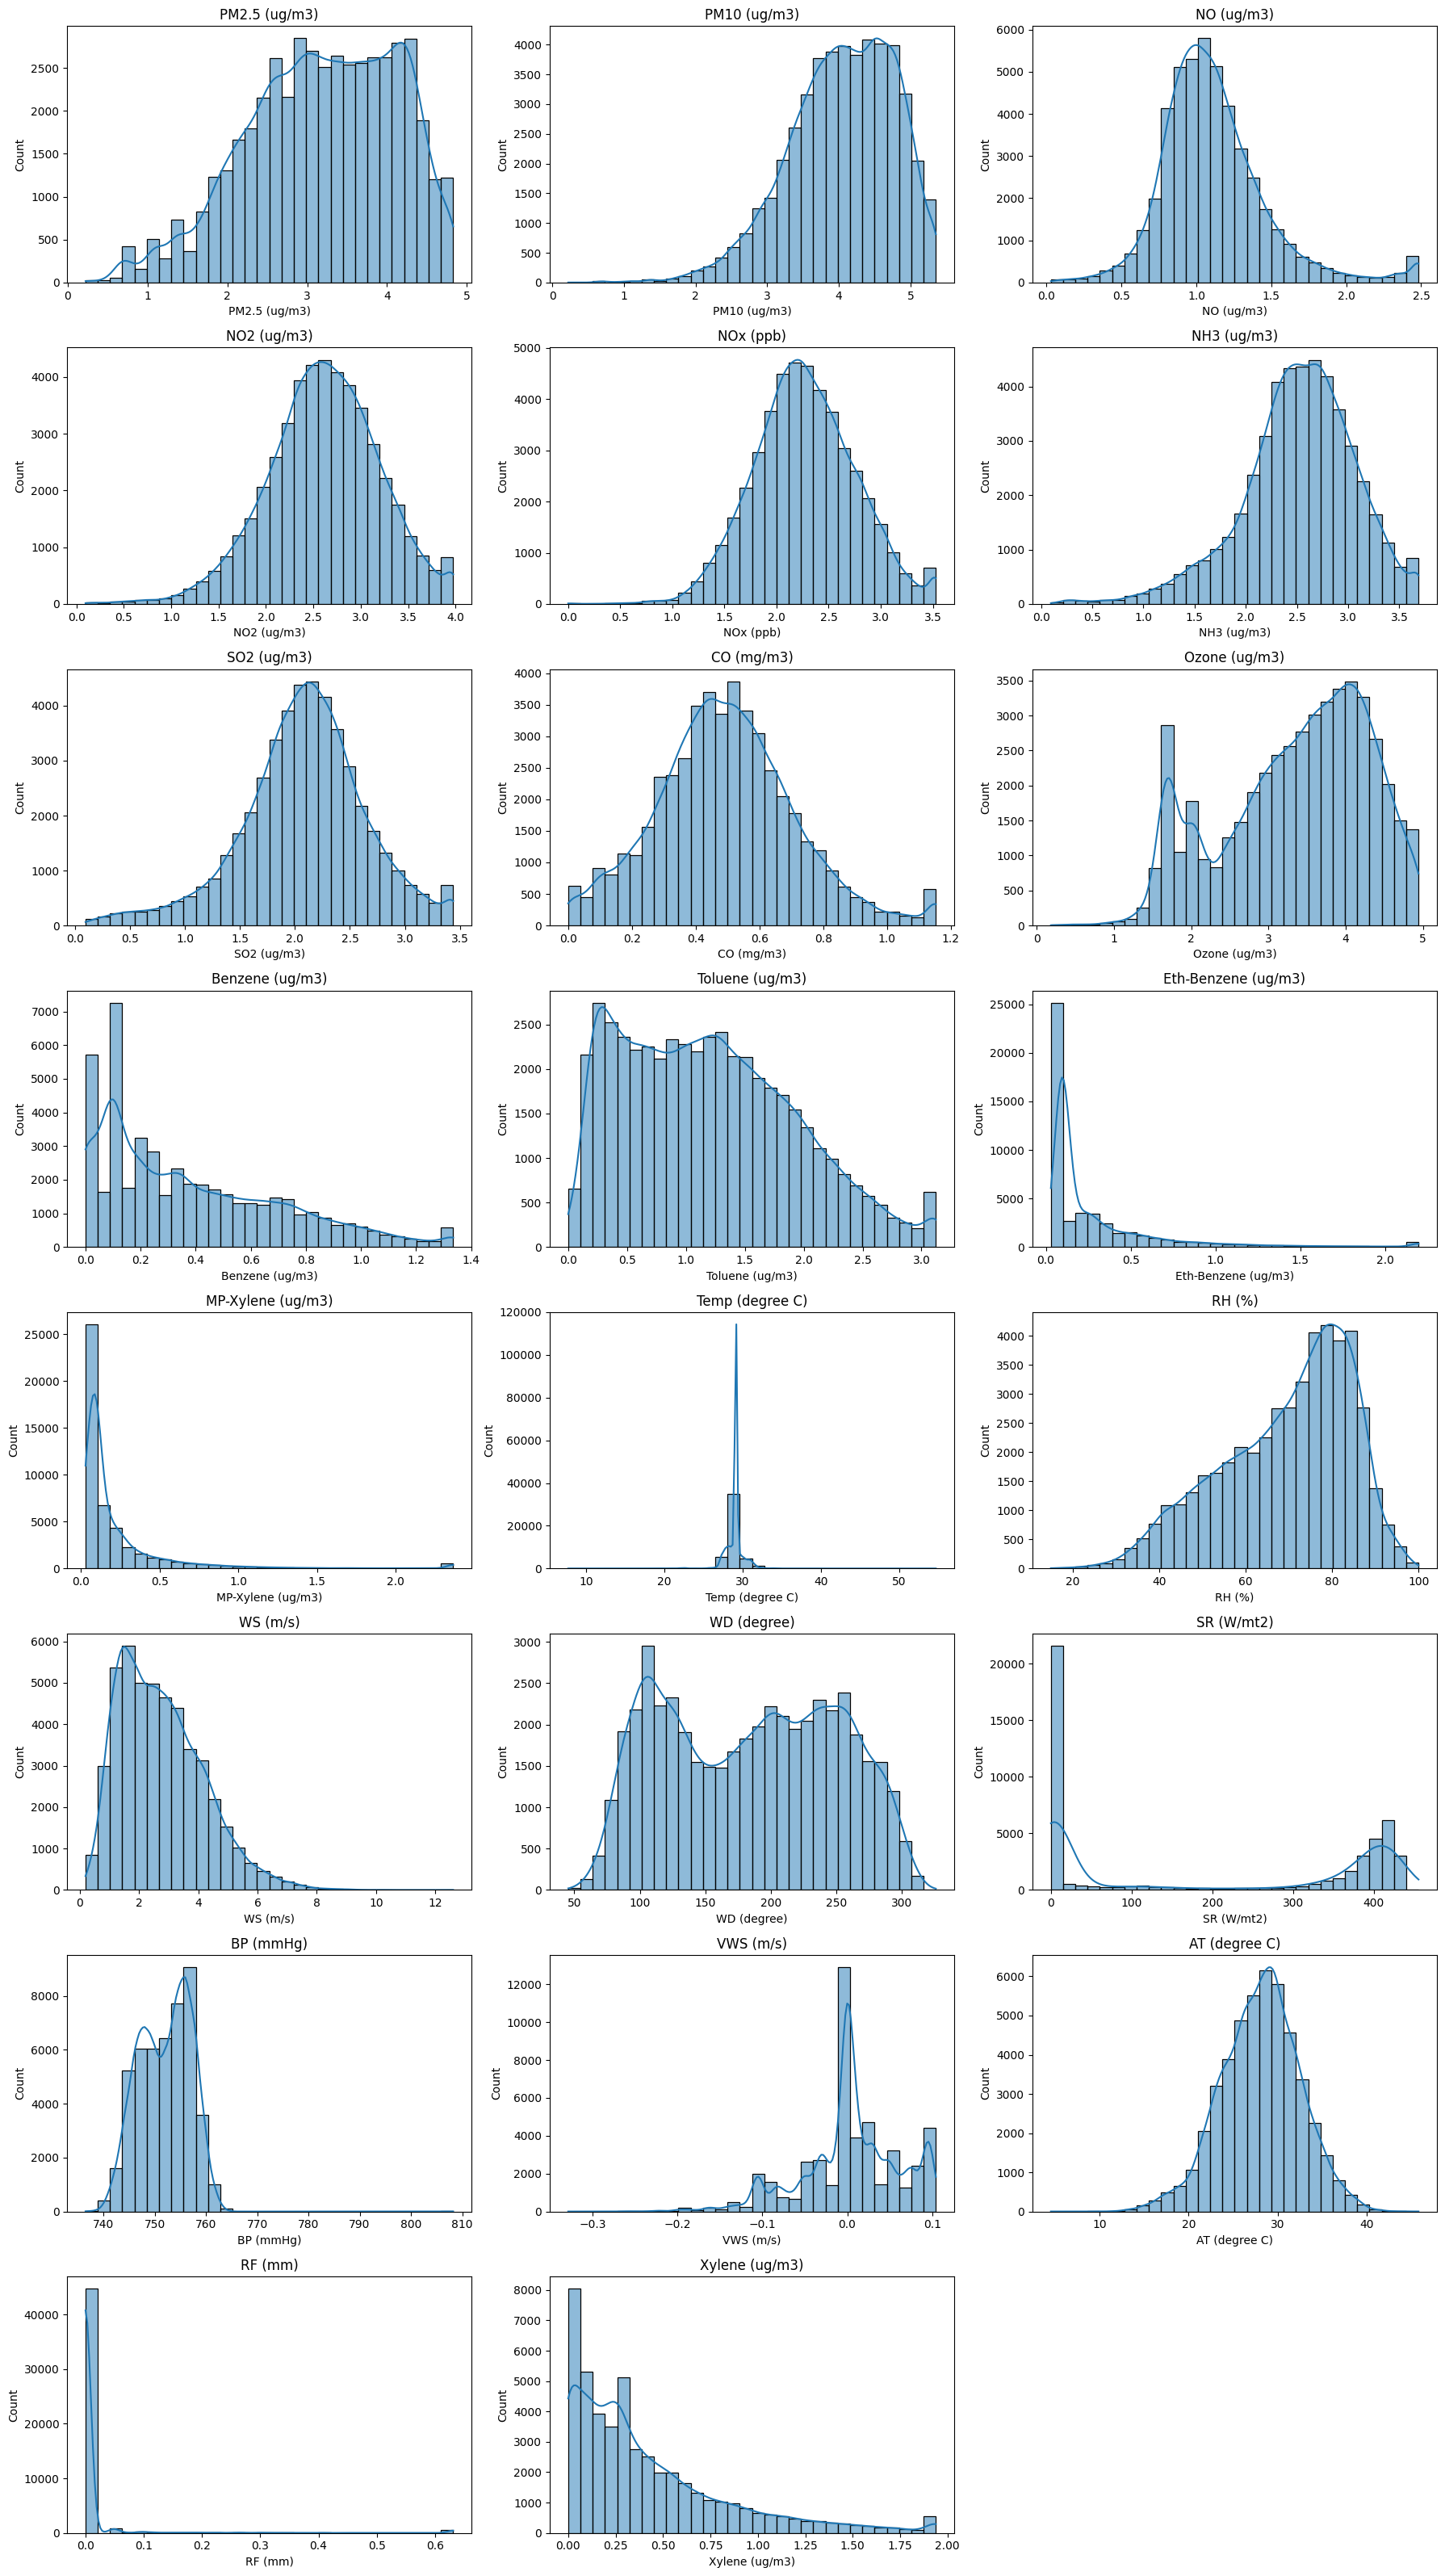

In [20]:
num_cols = [col for col in df.columns if df[col].dtype in ['float64', 'int64']]

n_cols = 3
n_rows = int(len(num_cols) / n_cols) + 1

plt.figure(figsize=(n_cols * 6, n_rows * 4))
for i, col in enumerate(num_cols):
    plt.subplot(n_rows, n_cols, i+1)
    sns.histplot(df[col], kde=True, bins=30)
    plt.title(col)
plt.tight_layout()
plt.show()


Mayoritas distribusi fitur polutan seperti PM2.5, PM10, NO, NO2, NOx, NH3, SO2, CO, Benzene, Toluene, MP-Xylene, Xylene, dan RF yang tadinya sangat right-skewed (mirip distribusi Pareto/eksponensial, heavy-tailed), kini menjadi jauh lebih simetris dan mendekati distribusi normal setelah diberi log1p dan capping. Ini terlihat dari kurva yang lebih “menggembung” di tengah, tidak lagi ekstrem pada sisi kanan. Hasilnya distribusi variabel kini lebih stabil dan jauh dari efek outlier ekstrim.

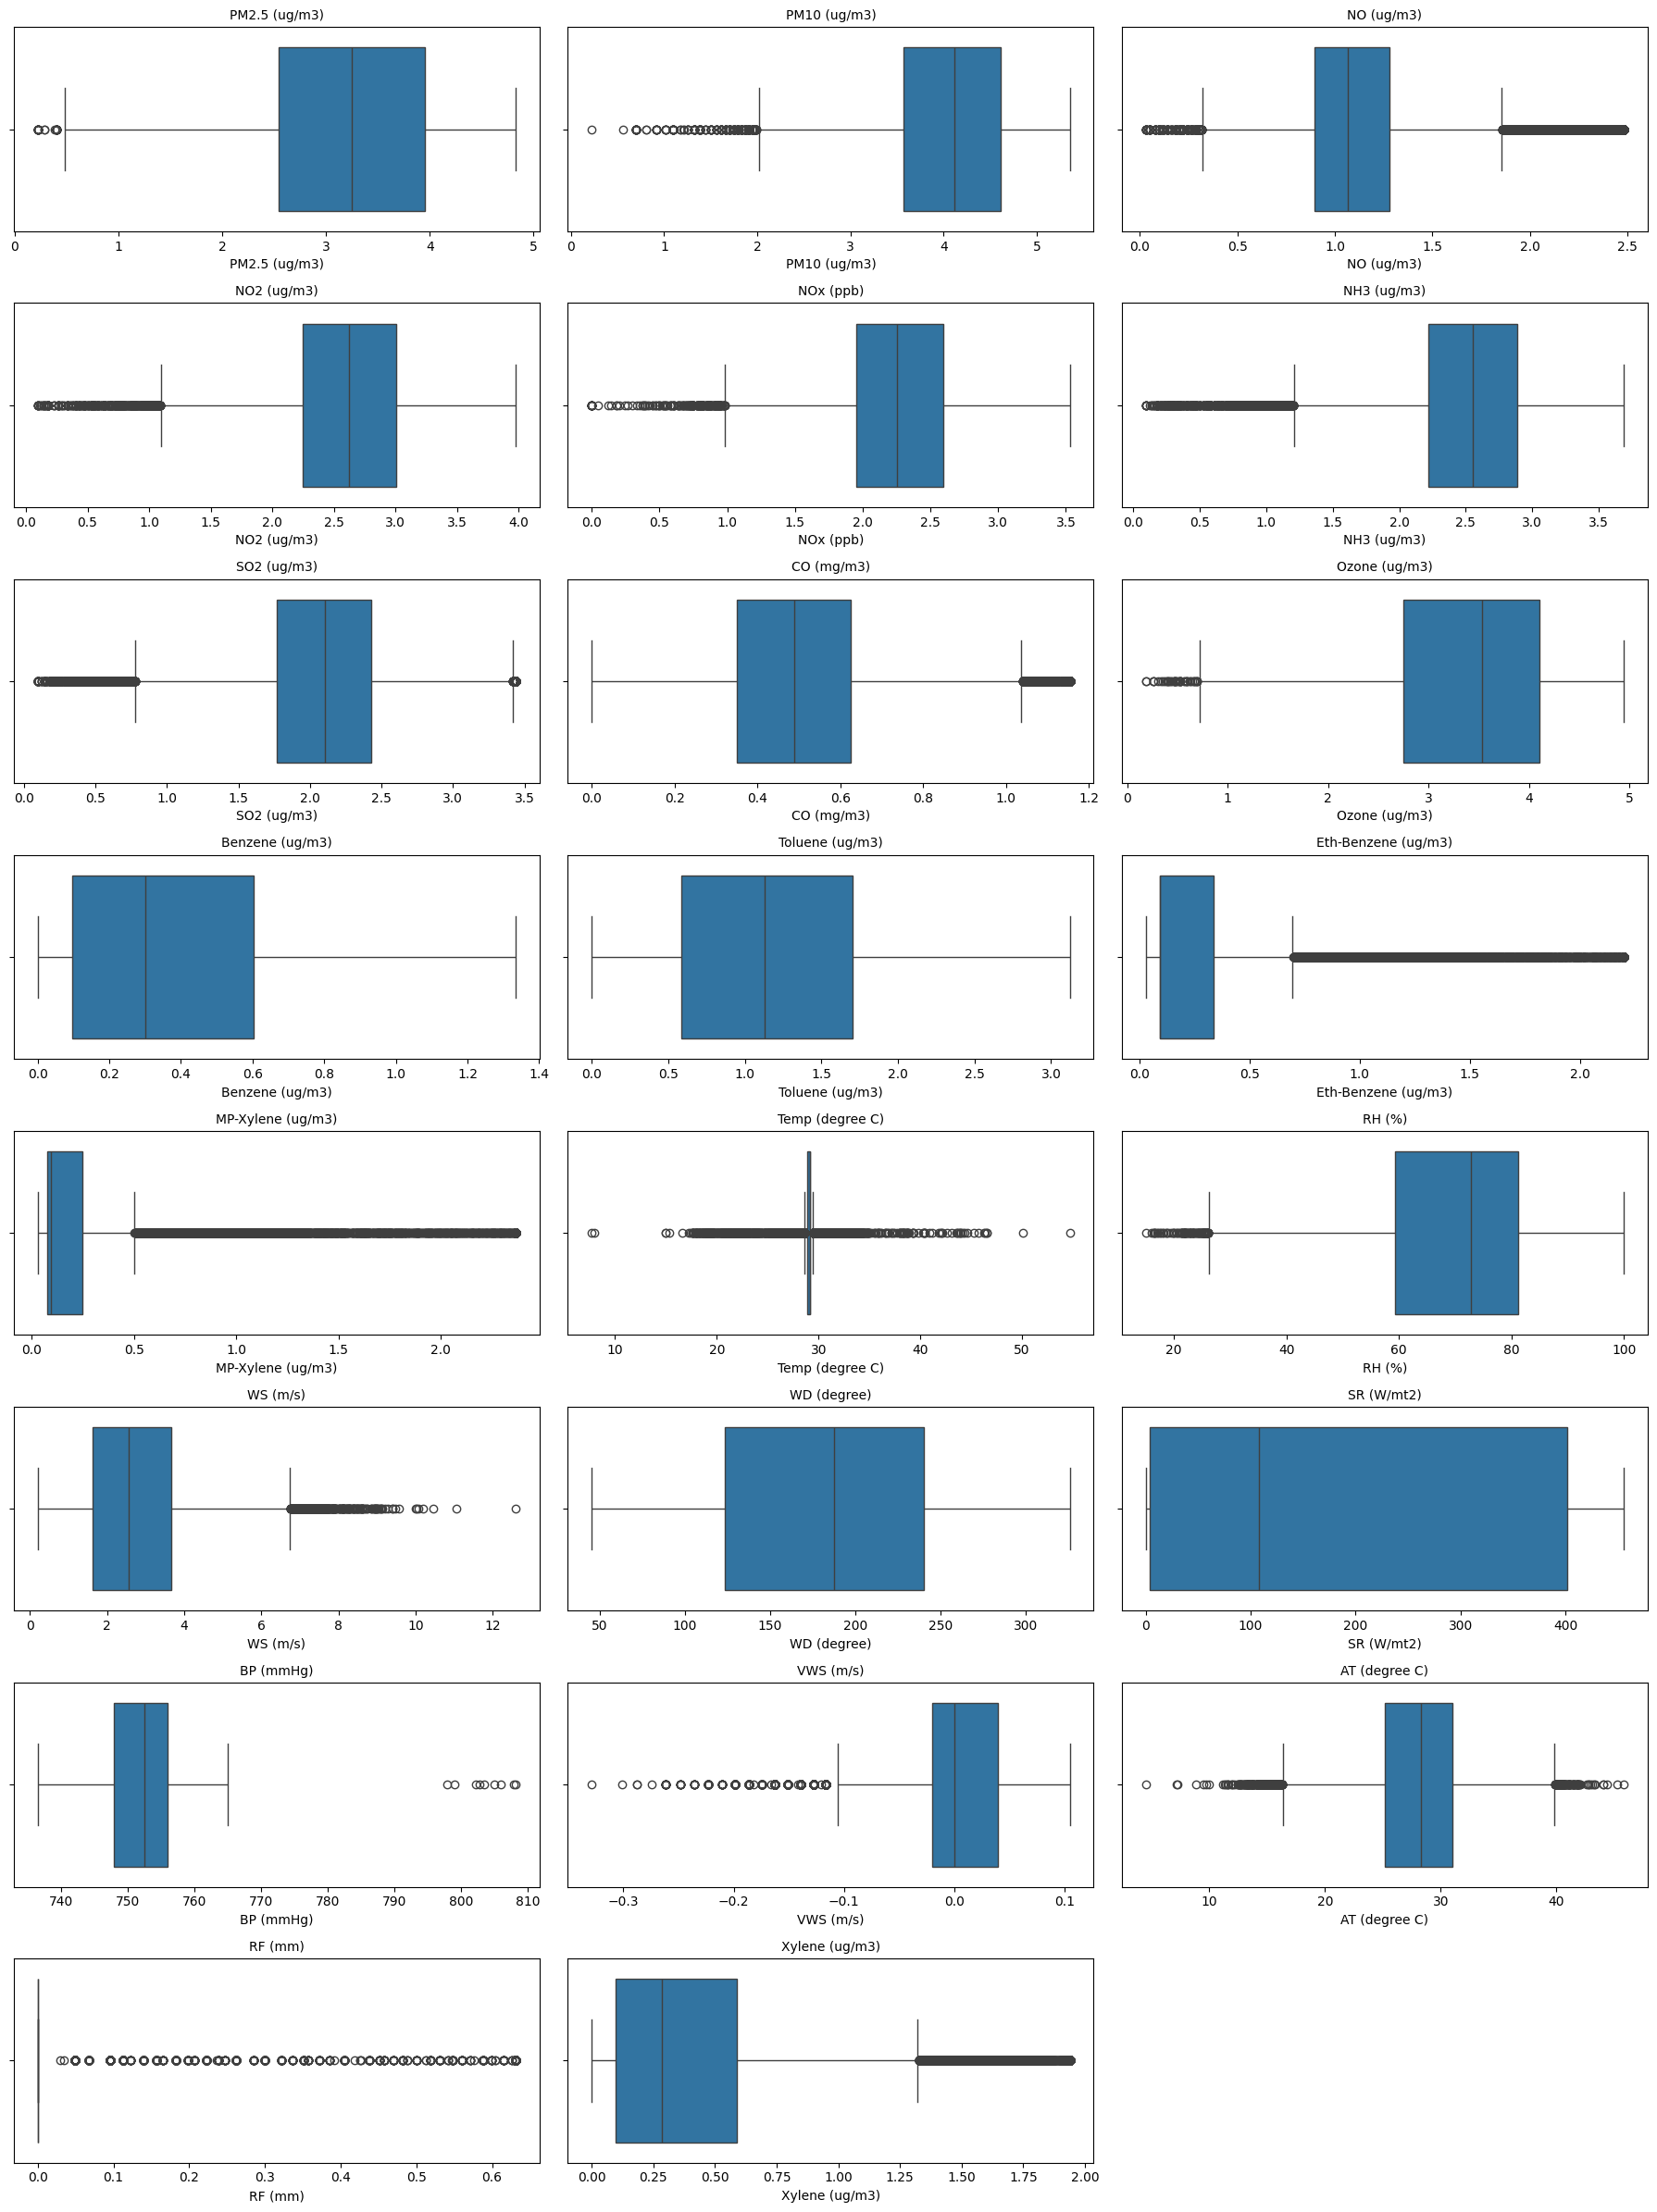

In [21]:
n_cols = 3
n_rows = int(len(num_cols) / n_cols) + 1

plt.figure(figsize=(n_cols * 6, n_rows * 3))
for i, col in enumerate(num_cols):
    plt.subplot(n_rows, n_cols, i+1)
    sns.boxplot(x=df[col])
    plt.title(col, fontsize=10)
plt.tight_layout()
plt.show()


## Tren Analysis

In [22]:
df['From Date'] = pd.to_datetime(df['From Date'])
df['Tahun'] = df['From Date'].dt.year

# Waktu → datetime & extra fitur waktu untuk visualiasi time series tren

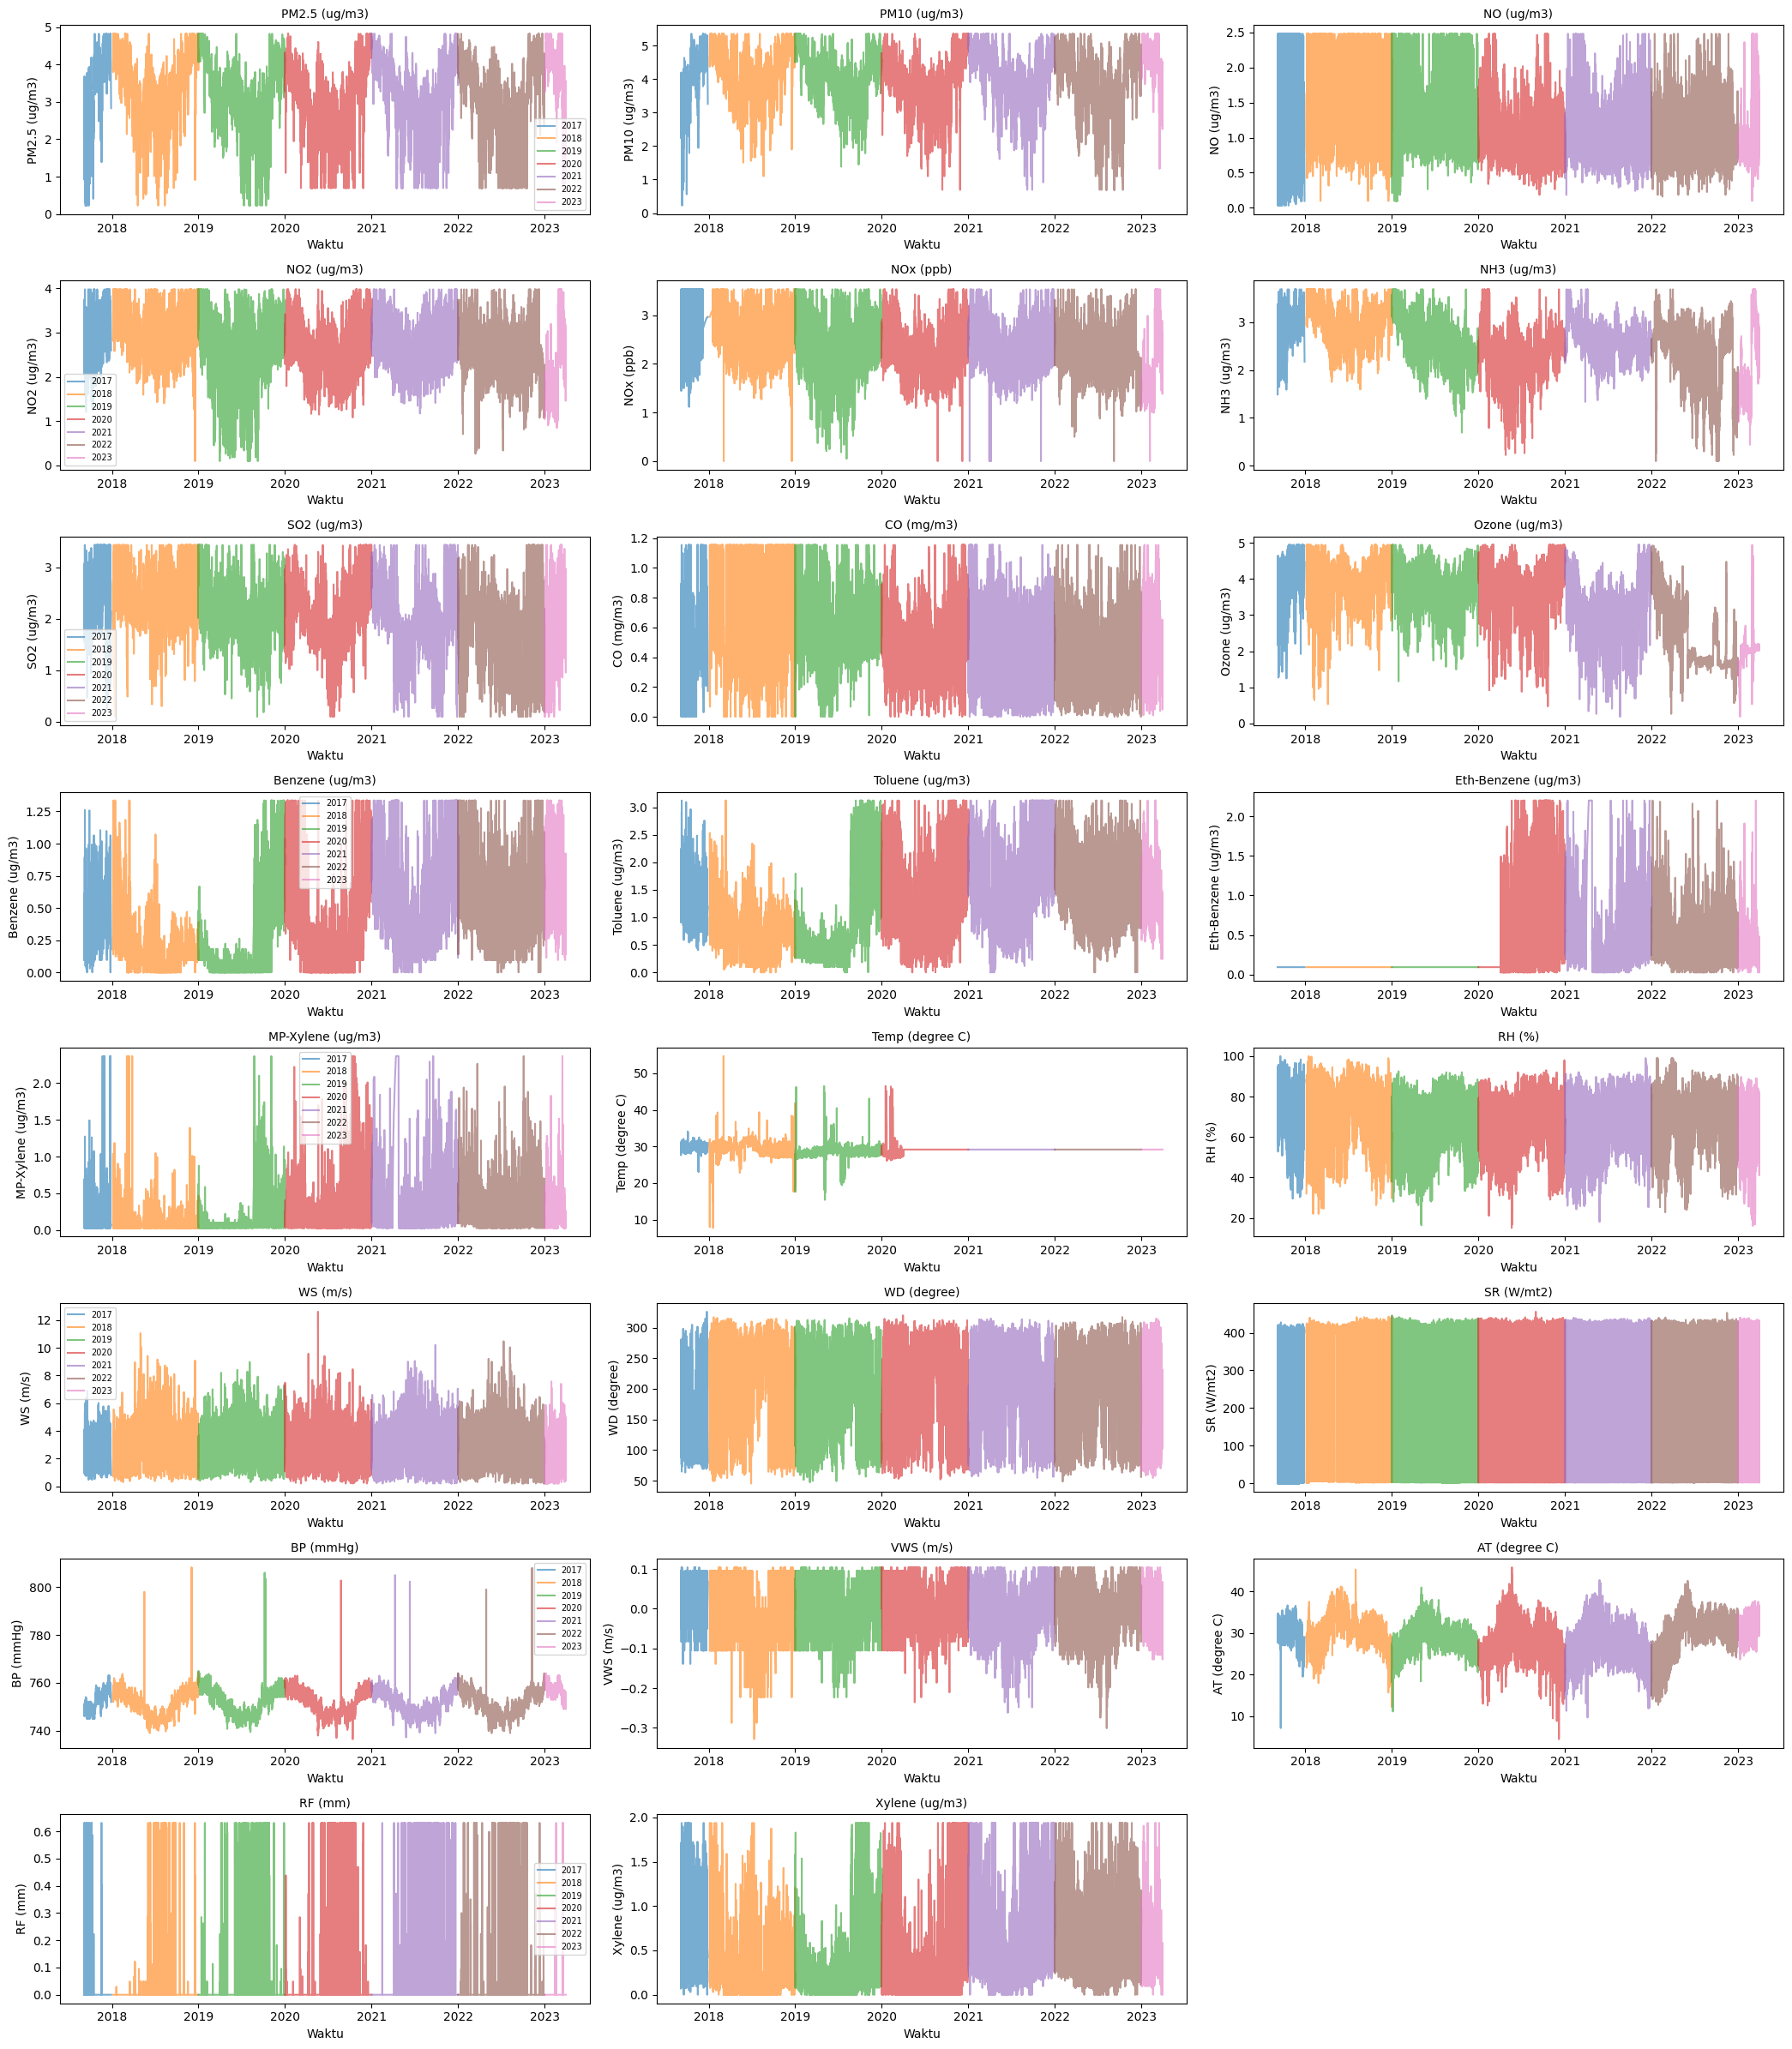

In [23]:
df['From Date'] = pd.to_datetime(df['From Date'])
df['Tahun'] = df['From Date'].dt.year

num_cols = [col for col in df.columns if col not in ['From Date', 'To Date', 'Tahun'] and df[col].dtype != 'object']
tahun_unik = sorted(df['Tahun'].unique())

n_cols = 3
n_rows = (len(num_cols) // n_cols) + int(len(num_cols) % n_cols > 0)

plt.figure(figsize=(n_cols*7, n_rows*3))

for i, col in enumerate(num_cols):
    plt.subplot(n_rows, n_cols, i+1)
    for tahun in tahun_unik:
        mask = df['Tahun'] == tahun
        plt.plot(df.loc[mask, 'From Date'], df.loc[mask, col], label=str(tahun), alpha=0.6)
    plt.title(col, fontsize=10)
    plt.xlabel('Waktu')
    plt.ylabel(col)
    if i % n_cols == 0:
        plt.legend(fontsize=7)
    else:
        plt.legend([],[], frameon=False)

plt.tight_layout()
plt.show()


## Analisis Tren Time Series per Tahun

- **Polutan udara dan fitur cuaca utama (PM2.5, PM10, NOx, SO2, CO, AT, RH, WS, SR)** menunjukkan pola naik turun yang jelas secara harian dan musiman (annual cycle). Hampir semua polutan udara menunjukkan fluktuasi harian dan musiman yang signifikan, dengan nilai puncak dan lembah di tahun-tahun tertentu.
- **Beberapa fitur hanya tercatat pada range tahun tertentu** (misal Toluene, Eth-Benzene, Temp) yang akan aku drop supaya tidak memengaruhi performa model.
- **Celah (gap) pada tahun tertentu** terlihat pada fitur polutan, artinya ada data missing atau stasiun hanya melakukan pengukuran di waktu tertentu.
- **Pola outlier/anomali** (spike/peak ekstrim) muncul pada BP, VWS, RF, dsb, menandakan kejadian cuaca ekstrim.
- **Tren AT (degree C) dan Temp** cukup periodik dan menunjukkan pola musiman (summer, rainy season, dsb), sangat cocok untuk prediksi time series menggunakan LSTM.



In [24]:
drop_cols = ['Temp (degree C)', 'Eth-Benzene (ug/m3)']
df = df.drop(columns=drop_cols)

Kedua kolom ini dihapus karena memiliki jumlah data valid yang sangat sedikit atau cakupan tahun yang tidak konsisten, sehingga tidak memberikan kontribusi yang stabil untuk modelling dan dapat menyebabkan bias atau error pada hasil prediksi.


## Feature engineering (log1p + capping outlier pada polutan)

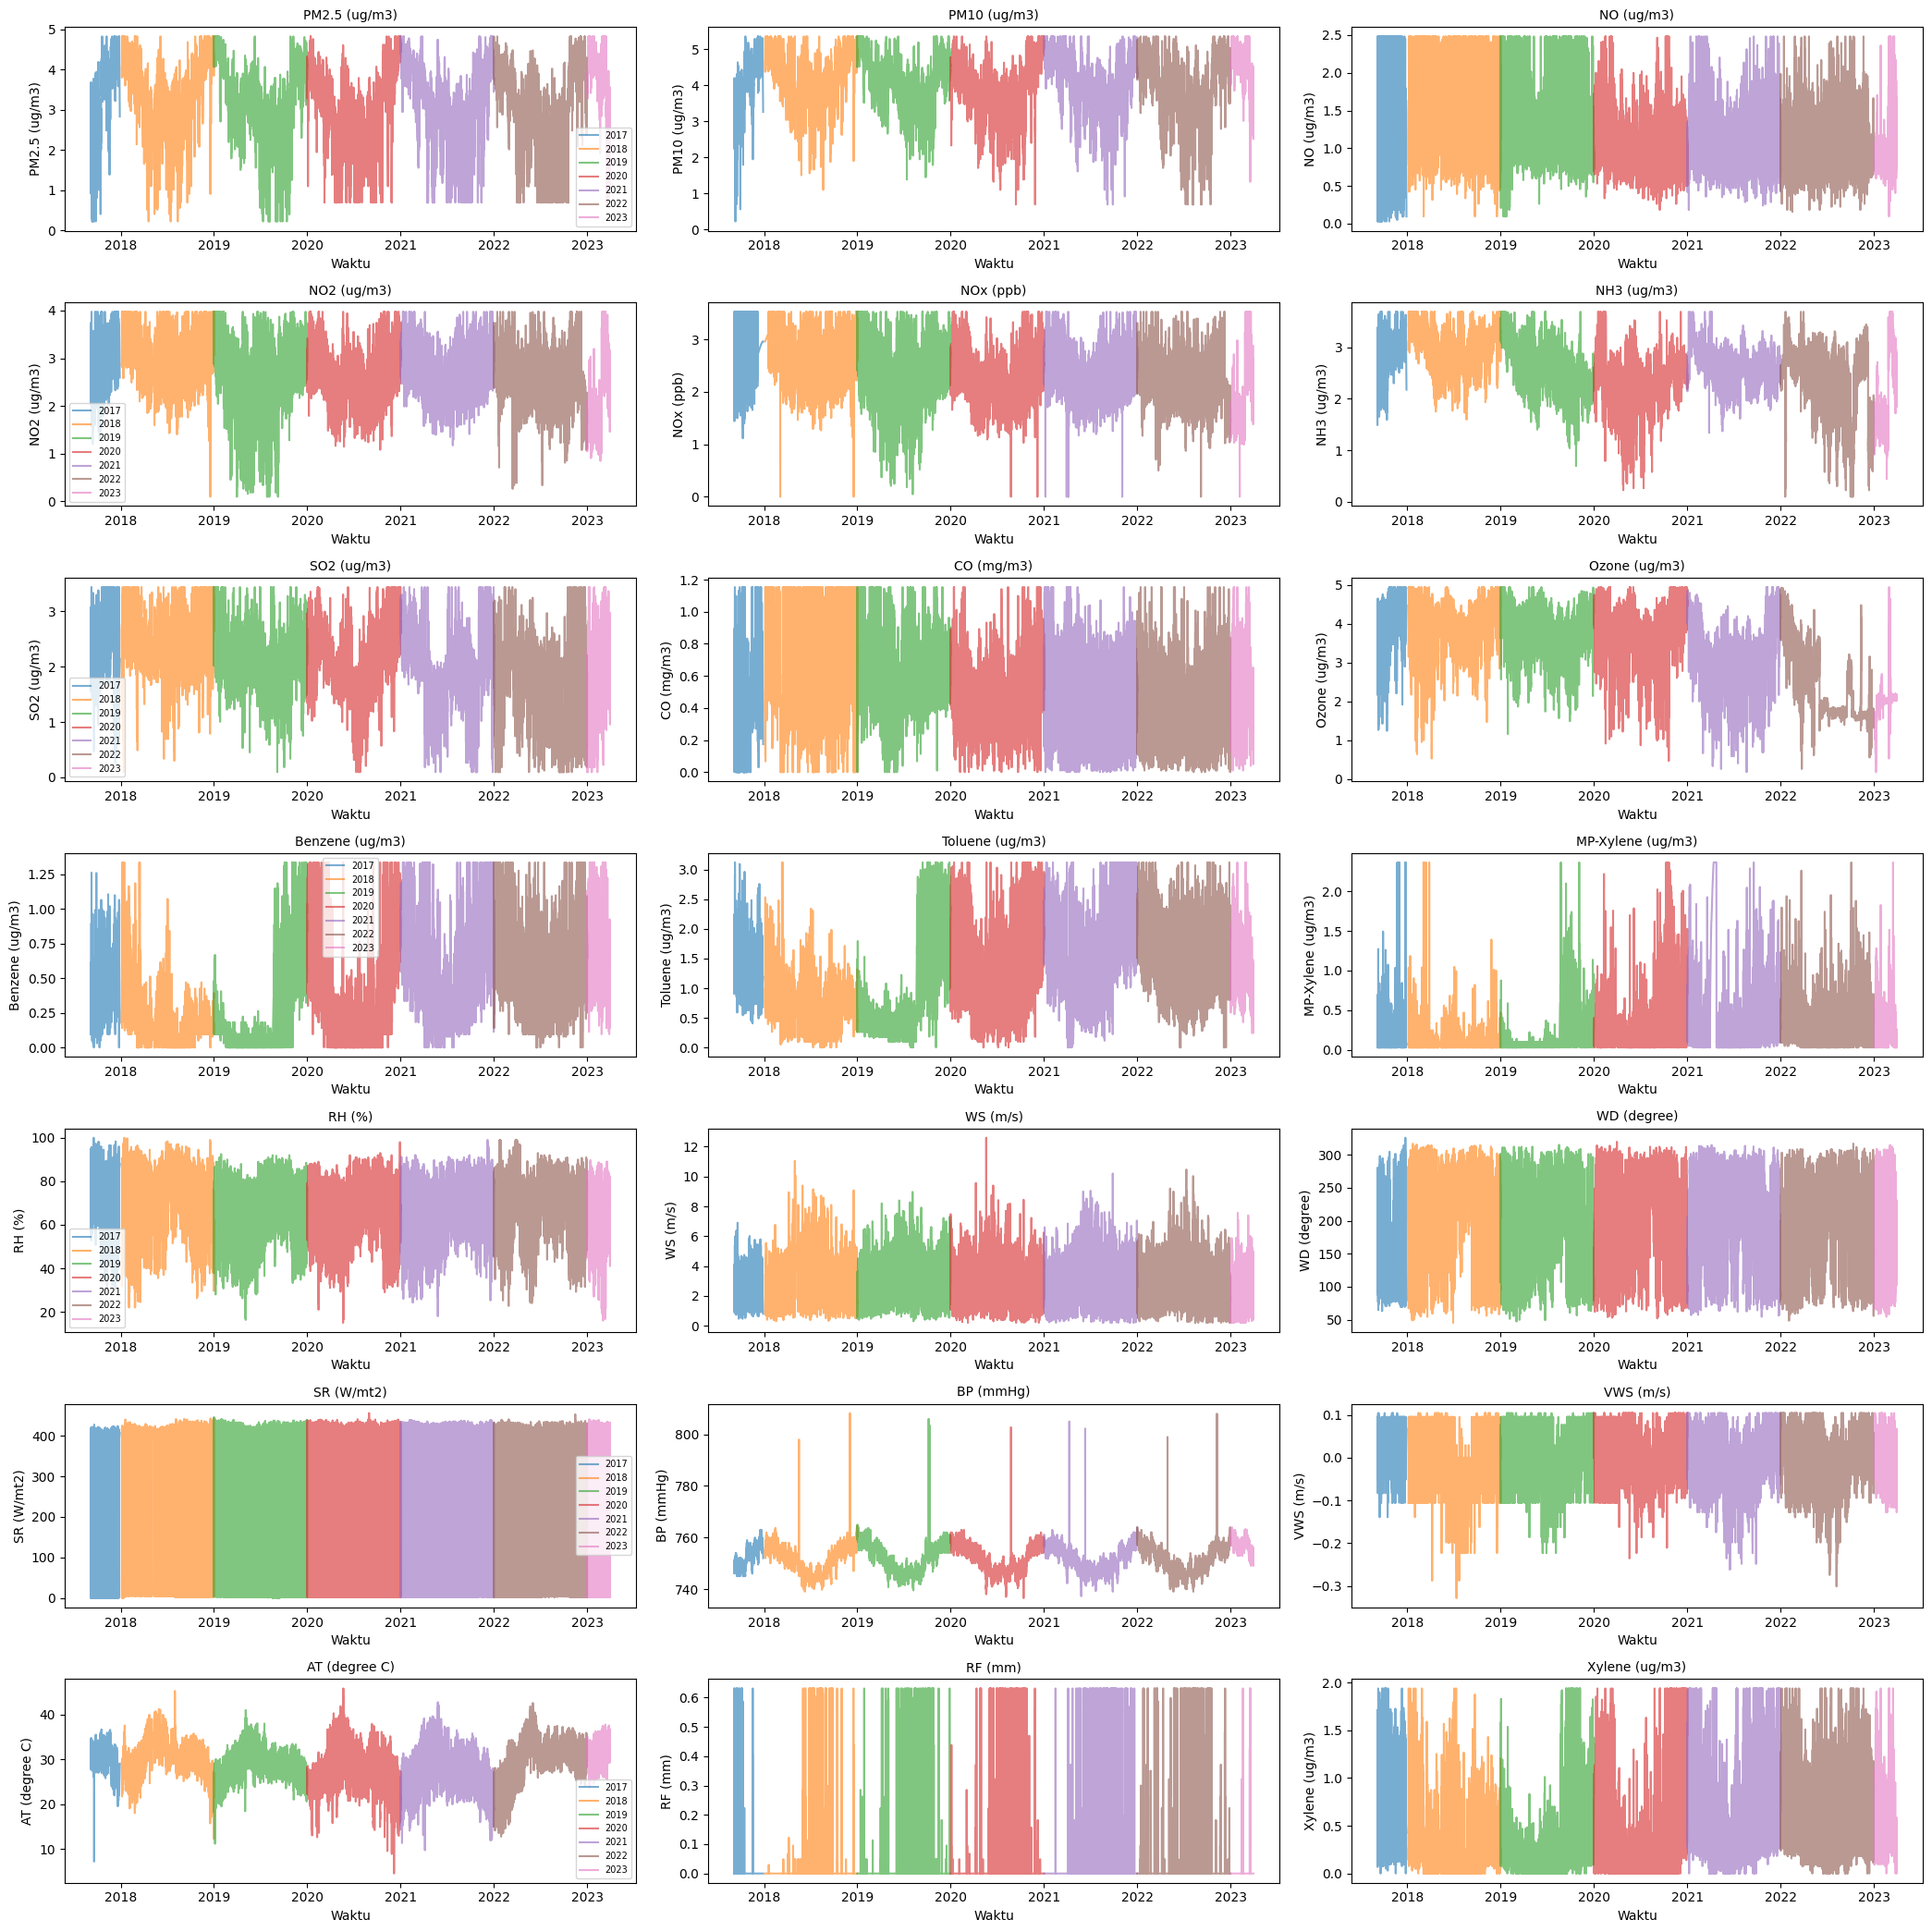

In [25]:
df['From Date'] = pd.to_datetime(df['From Date'])
df['Tahun'] = df['From Date'].dt.year

num_cols = [col for col in df.columns if col not in ['From Date', 'To Date', 'Tahun'] and df[col].dtype != 'object']
tahun_unik = sorted(df['Tahun'].unique())

n_cols = 3
n_rows = (len(num_cols) // n_cols) + int(len(num_cols) % n_cols > 0)

plt.figure(figsize=(n_cols*7, n_rows*3))

for i, col in enumerate(num_cols):
    plt.subplot(n_rows, n_cols, i+1)
    for tahun in tahun_unik:
        mask = df['Tahun'] == tahun
        plt.plot(df.loc[mask, 'From Date'], df.loc[mask, col], label=str(tahun), alpha=0.6)
    plt.title(col, fontsize=10)
    plt.xlabel('Waktu')
    plt.ylabel(col)
    if i % n_cols == 0:
        plt.legend(fontsize=7)
    else:
        plt.legend([],[], frameon=False)

plt.tight_layout()
plt.show()


In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 47286 entries, 0 to 48801
Data columns (total 24 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   From Date          47286 non-null  datetime64[ns]
 1   To Date            47286 non-null  object        
 2   PM2.5 (ug/m3)      47286 non-null  float64       
 3   PM10 (ug/m3)       47286 non-null  float64       
 4   NO (ug/m3)         47286 non-null  float64       
 5   NO2 (ug/m3)        47286 non-null  float64       
 6   NOx (ppb)          47286 non-null  float64       
 7   NH3 (ug/m3)        47286 non-null  float64       
 8   SO2 (ug/m3)        47286 non-null  float64       
 9   CO (mg/m3)         47286 non-null  float64       
 10  Ozone (ug/m3)      47286 non-null  float64       
 11  Benzene (ug/m3)    47286 non-null  float64       
 12  Toluene (ug/m3)    47286 non-null  float64       
 13  MP-Xylene (ug/m3)  47286 non-null  float64       
 14  RH (%)     

Kedua kolom tersebut berhasil dihilangkan

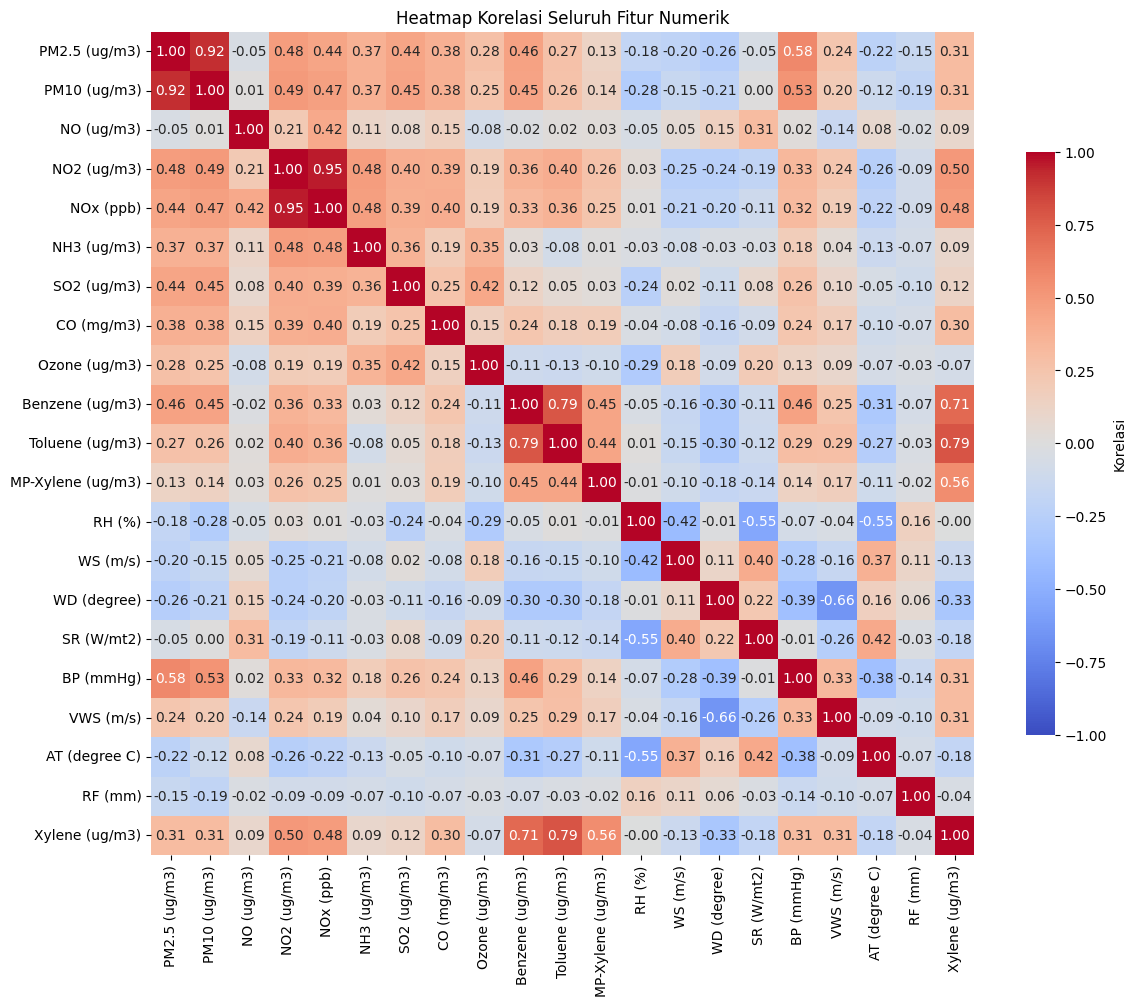

In [27]:
# Pilih semua kolom numerik kecuali waktu/objek
num_cols = [col for col in df.columns if col not in ['From Date', 'To Date', 'Tahun'] and df[col].dtype != 'object']

# Hitung korelasi Pearson
corr_matrix = df[num_cols].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', center=0, vmin=-1, vmax=1, square=True,
            cbar_kws={'shrink':0.7, 'label':'Korelasi'})
plt.title('Heatmap Korelasi Seluruh Fitur Numerik')
plt.tight_layout()
plt.show()


### Korelasi Antar-Fitur (Correlation Heatmap) untuk Semua Kolom Numerik
- Terdapat korelasi sangat kuat antara beberapa fitur polutan, misalnya antara **PM2.5** dan **PM10**, serta antara **NO**, **NO2**, dan **NOx**, masuk akal:)))
- Tapi, beberapa fitur cuaca seperti suhu udara (**AT (degree C)**), kelembapan (**RH (%)**), dan tekanan udara (**BP (mmHg)**) memiliki korelasi lemah atau bahkan negatif dengan polutan tertentu, yang menunjukkan adanya dinamika lingkungan yang kompleks.
- Ada grup polutan aromatik (misal: **Benzene**, **Toluene**, **MP-Xylene**, **Xylene**) yang saling berkorelasi sangat tinggi, menandakan kemungkinan berasal dari sumber emisi yang sama (misal lalu lintas atau industri).
- Korelasi antara **SR (W/mt2)** (solar radiation) dan **AT (degree C)** terbilang cukup tinggi (positif), menunjukkan bahwa kenaikan radiasi matahari umumnya diikuti kenaikan suhu

## STL Decomposition untuk Target

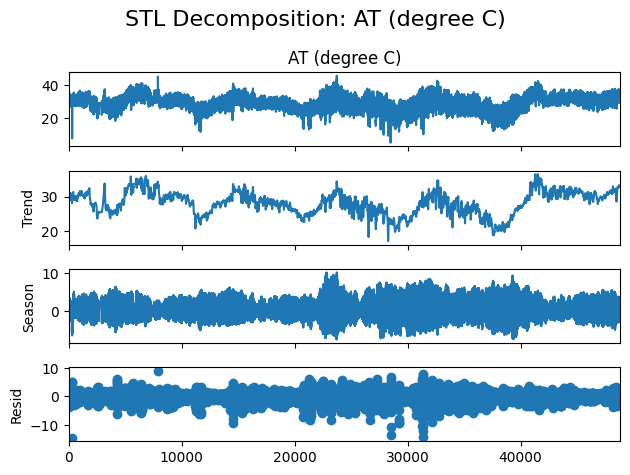

In [28]:
target = 'AT (degree C)'
if target in df.columns:
    series = df[target]
    stl = STL(series, period=24)  # Sesuaikan period jika bukan hourly
    result = stl.fit()
    result.plot()
    plt.suptitle(f"STL Decomposition: {target}", fontsize=16)
    plt.tight_layout()
    plt.show()

### STL Decomposition: AT (degree C)
- **Trend:** menunjukan perubahan jangka panjang pada suhu udara dari tahun ke tahun, terlihat ada naik-turun musiman serta kecenderungan perubahan suhu global.
- **Seasonal:** menunjukan pola musiman (harian/tahunan) yang konsisten, menunjukkan fluktuasi suhu yang berulang dalam periode waktu tertentu, misalnya karena perubahan musim atau pola siang-malam.
- **Residual (Resid):** Sisa aja yang tidak bisa dijelaskan oleh trend maupun seasonality, biasanya noise.

Dari hasil STL decomposition, tampak jelas bahwa:
- **AT (degree C)** memiliki komponen seasonal yang kuat dan konsisten sepanjang tahun, menandakan bahwa suhu udara sangat dipengaruhi oleh pola musiman. Komponen trend memperlihatkan adanya fluktuasi suhu antar tahun, kemungkinan akibat efek perubahan iklim atau variabel eksternal lain. Komponen residual relatif kecil, menandakan sebagian besar variasi suhu bisa dijelaskan oleh trend dan pola musiman.

# Preprocessing

# B

In [29]:
df = df.sort_values('From Date').reset_index(drop=True)

- **`From Date`** di-drop dari fitur input karena hanya digunakan sebagai penanda waktu/baris (indexing) untuk menjaga urutan data. Nilai waktu ini tidak digunakan secara langsung oleh model LSTM, karena pola waktu sudah terekam melalui struktur windowing input-output. Jadi, setelah proses pembuatan window dan sorting, `From Date` tidak diperlukan lagi dalam fitur prediktor.


## Split Data Train – Validation – Test (80:10:10, Berbasis Waktu)

In [30]:
n = len(df)
train_end = int(0.8 * n)
val_end = int(0.9 * n)
df_train = df.iloc[:train_end]
df_val   = df.iloc[train_end:val_end]
df_test  = df.iloc[val_end:]

Sesuai soal, aku lakukan tain test val split sebesar 80:10:10, dimana disini aku pakai time series split, bukan simple random sampling jareba data tidak boleh dishuffle karena mengandung pola dan depedesi temporal

## Pisahkan Fitur dan Target


In [31]:
feature_cols = [col for col in df.columns if col not in ['From Date', 'To Date', 'Tahun', 'AT (degree C)']]
target_col = 'AT (degree C)'

- **Fitur (`feature_cols`)** berisi semua variabel input yang digunakan untuk memprediksi target, kecuali kolom waktu (`From Date`, `To Date`), variabel tahun (`Tahun`), dan kolom target (`AT (degree C)`).
- **Target (`target_col`)** hanya berisi kolom `AT (degree C)` sebagai variabel yang akan diprediksi.


## Scaling Fitur dan Target

In [32]:
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_train = scaler_X.fit_transform(df_train[feature_cols])
X_val   = scaler_X.transform(df_val[feature_cols])
X_test  = scaler_X.transform(df_test[feature_cols])

y_train = scaler_y.fit_transform(df_train[[target_col]])
y_val   = scaler_y.transform(df_val[[target_col]])
y_test  = scaler_y.transform(df_test[[target_col]])

### Min-Max Scaling pada Input & Target
Min-Max Scaling bertujuan agar semua fitur berada pada skala yang seragam, sehingga model LSTM dapat belajar lebih stabil dan menghindari dominasi fitur dengan nilai besar. Selain itu, scaling ini membantu proses training menjadi lebih cepat konvergen dan hasil prediksi tetap terjaga dalam rentang yang diharapkan.

## Windowing Input–Output

In [33]:
def create_sequences(X, y, window_size=5):
    Xs, ys = [], []
    for i in range(len(X) - window_size):
        Xs.append(X[i:i+window_size])
        ys.append(y[i+window_size])
    return np.array(Xs), np.array(ys)

window_size = 5
X_train_seq, y_train_seq = create_sequences(X_train, y_train, window_size)
X_val_seq, y_val_seq     = create_sequences(X_val, y_val, window_size)
X_test_seq, y_test_seq   = create_sequences(X_test, y_test, window_size)

Sesuai dengan permintaan soal, agar data time series dapat digunakan sebagai input untuk model LSTM, dilakukan proses _windowing_, dari soal **setiap sampel input** dibentuk dari data historis selama **5 jam terakhir** (input_steps=5), mencakup seluruh fitur numerik yang sudah dipilih sebelumnya dan**target output** adalah nilai **`AT (degree C)`** pada **1 jam ke depan** (_output_steps=1_). Proses ini menghasilkan dataset tiga dimensi (`samples, window, features`) yang siap untuk dimasukkan ke arsitektur LSTM.

  
Dengan menggunakan windowing, model akan dapat **belajar pola temporal jangka pendek** dan memprediksi suhu udara berdasarkan pola dan interaksi antar variabel polutan dan cuaca pada 5 jam terakhir.


In [34]:
print("Contoh satu window (X_train_seq[0]):")
print(X_train_seq[0])
print("Target window itu (y_train_seq[0]):")
print(y_train_seq[0])


Contoh satu window (X_train_seq[0]):
[[0.65903167 0.70283997 0.4077146  0.64032259 0.61940127 0.64599049
  0.53578986 0.26011647 0.88316816 0.07139334 0.48171096 0.028146
  0.63529412 0.24193548 0.59739195 0.81623697 0.14634146 0.97909312
  0.         0.20913829]
 [0.64165061 0.72103369 0.1921102  0.68254265 0.6312479  0.61023578
  0.48235565 0.29780731 0.83335695 0.10469051 0.43007939 0.02029134
  0.65294118 0.31451613 0.33730003 0.63795941 0.14982578 0.87162286
  0.         0.20221471]
 [0.59092179 0.74377923 0.64410075 0.83020381 0.82519276 0.52415421
  0.52424286 0.27916675 0.74404211 0.31855236 0.44796714 0.03966419
  0.85882353 0.21129032 0.46111091 0.65880417 0.14634146 0.75890812
  1.         0.21935245]
 [0.61005404 0.64676048 0.38217872 0.78093244 0.7461334  0.59424136
  0.52187898 0.33980355 0.71083681 0.29366425 0.56737659 0.09301952
  0.86764706 0.12258065 0.66330566 0.49478881 0.15679443 0.75890812
  0.         0.54020554]
 [0.53959062 0.61290728 0.28456339 0.82832837 0.7

# C & E (Evaluasi C)

## Model Baseline LSTM

In [36]:
n_timesteps = 5        # Panjang window
n_features = X_train_seq.shape[2]  # Banyak fitur input
hidden_size = 10       # Hidden size LSTM

model = Sequential([
    Input(shape=(n_timesteps, n_features)),
    LSTM(hidden_size),
    Dense(1, activation='linear')  # Output regressor, linear
])

model.compile(
    optimizer='adam',
    loss='mse',
    metrics=['mae']
)

model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 10)             │         1,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,251 (4.89 KB)

 Trainable params: 1,251 (4.89 KB)

 Non-trainable params: 0 (0.00 B)

Model baseline menggunakan arsitektur **LSTM** sederhana, sesuai dengan keiinginan soal
- **1 layer LSTM** dengan ukuran hidden 10 unit (hidden size = 10).
- **1 layer Dense** (regressor) dengan 1 output neuron, fungsi aktivasi linear.
- **Input:** window data 5 jam terakhir dari seluruh fitur numerik (20 fitur).
- **Target:** memprediksi suhu udara (**AT (degree C)**) 1 jam ke depan.

## Training Model

In [37]:
# Callback
callbacks = [
    EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)
]

history = model.fit(
    X_train_seq, y_train_seq,
    validation_data=(X_val_seq, y_val_seq),
    epochs=50,
    batch_size=32,
    callbacks=callbacks,
    verbose=1
)


Epoch 1/50
1182/1182 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - loss: 0.0362 - mae: 0.1128 - val_loss: 0.0116 - val_mae: 0.0913
Epoch 2/50
1182/1182 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - loss: 0.0044 - mae: 0.0527 - val_loss: 0.0070 - val_mae: 0.0706
Epoch 3/50
1182/1182 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - loss: 0.0040 - mae: 0.0498 - val_loss: 0.0065 - val_mae: 0.0681
Epoch 4/50
1182/1182 ━━━━━━━━━━━━━━━━━━━━ 13s 8ms/step - loss: 0.0037 - mae: 0.0482 - val_loss: 0.0061 - val_mae: 0.0658
Epoch 5/50
1182/1182 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - loss: 0.0035 - mae: 0.0467 - val_loss: 0.0064 - val_mae: 0.0679
Epoch 6/50
1182/1182 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - loss: 0.0033 - mae: 0.0451 - val_loss: 0.0071 - val_mae: 0.0719
Epoch 7/50
1182/1182 ━━━━━━━━━━━━━━━━━━━━ 13s 9ms/step - loss: 0.0031 - mae: 0.0437 - val_loss: 0.0075 - val_mae: 0.0745
Epoch 8/50
1182/1182 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - loss: 0.0030 - mae: 0.0427 - val_loss: 0.0077 - val_mae: 0.0754
Epoch 9/50
1182/1182 ━━━━━━━━━━━━━━━━

Disini aku mencoba 50 epoch dengan callback patience 7 untuk mencegah model overfit

In [38]:
# Prediksi pada test set
y_pred_scaled = model.predict(X_test_seq)
y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_test_true = scaler_y.inverse_transform(y_test_seq)

# Hitung metrik
mse = mean_squared_error(y_test_true, y_pred)
mae = mean_absolute_error(y_test_true, y_pred)
r2  = r2_score(y_test_true, y_pred)

print(f"Test MAE  : {mae:.4f}")
print(f"Test MSE  : {mse:.4f}")
print(f"Test R^2  : {r2:.4f}")

148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Test MAE  : 5.6230
Test MSE  : 36.8447
Test R^2  : -4.1124


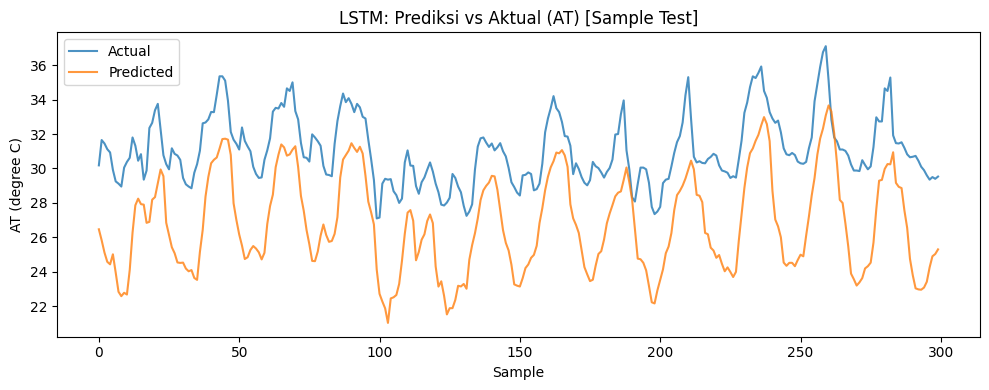

In [39]:
plt.figure(figsize=(10,4))
plt.plot(y_test_true[:300], label='Actual', alpha=0.8)
plt.plot(y_pred[:300], label='Predicted', alpha=0.8)
plt.title('LSTM: Prediksi vs Aktual (AT) [Sample Test]')
plt.ylabel('AT (degree C)')
plt.xlabel('Sample')
plt.legend()
plt.tight_layout()
plt.show()

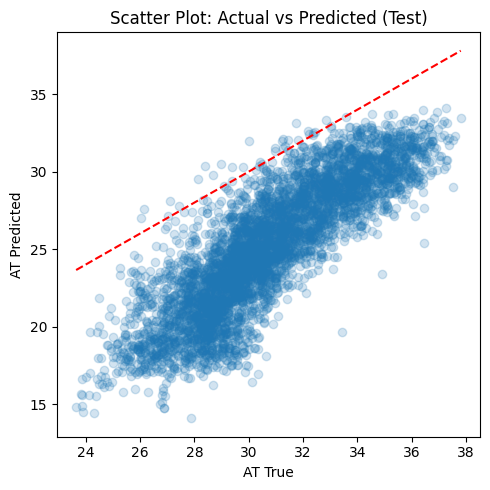

In [40]:
plt.figure(figsize=(5,5))
plt.scatter(y_test_true, y_pred, alpha=0.2)
plt.xlabel('AT True')
plt.ylabel('AT Predicted')
plt.title('Scatter Plot: Actual vs Predicted (Test)')
plt.plot([y_test_true.min(), y_test_true.max()],
         [y_test_true.min(), y_test_true.max()], 'r--')
plt.tight_layout()
plt.show()

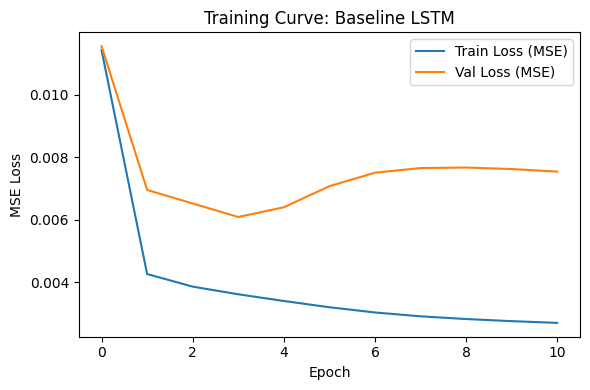

In [41]:
plt.figure(figsize=(6, 4))
plt.plot(history.history['loss'], label='Train Loss (MSE)')
plt.plot(history.history['val_loss'], label='Val Loss (MSE)')
plt.title('Training Curve: Baseline LSTM')
plt.ylabel('MSE Loss')
plt.xlabel('Epoch')
plt.legend()
plt.tight_layout()
plt.show()

#### Evaluasi Model Baseline LSTM

| Metric  | Test Set Value |
|---------|----------------|
| MAE     | 5.6230         |
| MSE     | 36.8447        |
| R²      | -4.1124        |

- **MAE (5.62) dan MSE (36.84)** menunjukkan prediksi suhu udara aktual (AT) oleh model masih meleset cukup jauh, model belum cukup akurat.
- **R² Score negatif (-4.11)** artinya performa model jauh di bawah baseline sederhana bahkan dibawah 0, menandakan model gagal menangkap pola generalisasi yang baik pada data baru.
- **Training curve** menunjukkan gap antara train loss dan val loss, serta val loss yang stagnan/meningkat, ini adalah ciri-ciri overfitting.
- **Visualisasi prediksi vs aktual dan scatter plot** memperlihatkan model sering **underestimate** yang arkhinya menyebabkannya belum bisa mengikuti fluktuasi aktual, terutama pada periode perubahan ekstrem.

**Kemungkinan yang Terjadi dan apa yang bisa Dilakukan:**  
- Model baseline (1 LSTM, 10 unit) **masih terlalu sederhana** untuk data multivariat kompleks seperti ini, bisa menambah dense, atau megubah arsitektur model seperti (misal: stacked LSTM, hidden size lebih besar, penambahan Dropout).
- **Perpanjang window input** agar model bisa menangkap pola musiman/harian yang lebih panjang(tidak bisa karena soal).
- Lakukan **hyperparameter tuning**, yang akan kucoba lakukan setelah modifikasi untuk menentukan yang mana yang lebih bagus antara baseline dan modifikasi untuk dihypertune
- Tambahkan **regularisasi** (Dropout) untuk mengurangi risiko overfitting.


# D dan E (Eval D)

## Modifikasi Model

In [42]:
n_timesteps = 5
n_features = X_train_seq.shape[2]

model_modif = Sequential([
    Input(shape=(n_timesteps, n_features)),
    LSTM(32, return_sequences=True),         # Layer LSTM 1 (besar, return_sequences untuk stack)
    Dropout(0.3),                            # Dropout antar LSTM
    LSTM(16),                                # Layer LSTM 2
    Dropout(0.3),                            # Dropout sebelum regressor
    Dense(1, activation='linear')            # Output layer
])

model_modif.compile(
    optimizer='adam',
    loss='mse',
    metrics=['mae']
)

model_modif.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, 5, 32)          │         6,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 5, 32)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 16)             │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,937 (38.82 KB)

 Trainable params: 9,937 (38.82 KB)

 Non-trainable params: 0 (0.00 B)

In [43]:
callbacks = [
    EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)
]

history_modif = model_modif.fit(
    X_train_seq, y_train_seq,
    validation_data=(X_val_seq, y_val_seq),
    epochs=50,
    batch_size=32,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/50
1182/1182 ━━━━━━━━━━━━━━━━━━━━ 12s 8ms/step - loss: 0.0191 - mae: 0.1056 - val_loss: 0.0084 - val_mae: 0.0761
Epoch 2/50
1182/1182 ━━━━━━━━━━━━━━━━━━━━ 13s 11ms/step - loss: 0.0060 - mae: 0.0611 - val_loss: 0.0071 - val_mae: 0.0706
Epoch 3/50
1182/1182 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - loss: 0.0043 - mae: 0.0517 - val_loss: 0.0069 - val_mae: 0.0691
Epoch 4/50
1182/1182 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - loss: 0.0037 - mae: 0.0481 - val_loss: 0.0073 - val_mae: 0.0720
Epoch 5/50
1182/1182 ━━━━━━━━━━━━━━━━━━━━ 20s 9ms/step - loss: 0.0035 - mae: 0.0462 - val_loss: 0.0083 - val_mae: 0.0781
Epoch 6/50
1182/1182 ━━━━━━━━━━━━━━━━━━━━ 22s 10ms/step - loss: 0.0033 - mae: 0.0449 - val_loss: 0.0078 - val_mae: 0.0754
Epoch 7/50
1182/1182 ━━━━━━━━━━━━━━━━━━━━ 21s 10ms/step - loss: 0.0032 - mae: 0.0440 - val_loss: 0.0072 - val_mae: 0.0721
Epoch 8/50
1182/1182 ━━━━━━━━━━━━━━━━━━━━ 19s 9ms/step - loss: 0.0030 - mae: 0.0428 - val_loss: 0.0080 - val_mae: 0.0765
Epoch 9/50
1182/1182 ━━━━━━━━

Sama disini aku mencoba 50 epoch dengan callback patience 7 untuk mencegah model overfit

Untuk mencoba meningkatkan performa model, aku coba modifikasi dengan detaill sebagai berikut:
- Menambah Layer LSTM dari 1 menjadi 2 layer LSTM (stacked). Layer pertama memakai return_sequences=True agar outputnya bisa masuk ke LSTM kedua.
- Ukuran Hidden Unit Diperbessar, layer LSTM pertama diperbesar (32 units), layer kedua lebih kecil (16 units) agar fitur yang ditangkap lebih beragam namun tetap efisien.
- Penambahan Dropout sebesar 0.3 setelah masing-masing layer LSTM untuk mengurangi risiko overfitting.


In [54]:
# Prediksi test set
y_pred_modif_scaled = model_modif.predict(X_test_seq)
y_pred_modif = scaler_y.inverse_transform(y_pred_modif_scaled)
y_test_true  = scaler_y.inverse_transform(y_test_seq)

# Hitung metrik
mse_modif = mean_squared_error(y_test_true, y_pred_modif)
mae_modif = mean_absolute_error(y_test_true, y_pred_modif)
r2_modif  = r2_score(y_test_true, y_pred_modif)

print(f"Modif Test MAE  : {mae_modif:.4f}")
print(f"Modif Test MSE  : {mse_modif:.4f}")
print(f"Modif Test R^2  : {r2_modif:.4f}")


148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Modif Test MAE  : 4.8864
Modif Test MSE  : 29.1163
Modif Test R^2  : -3.0400


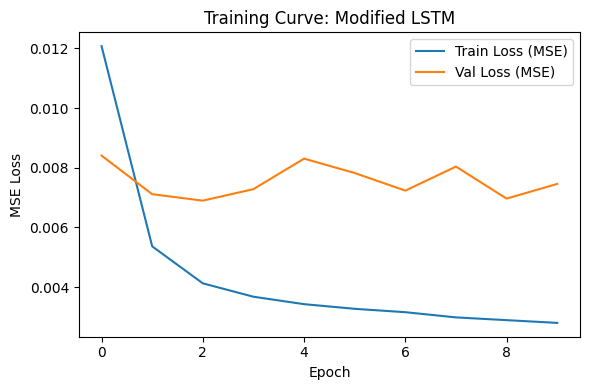

In [45]:
plt.figure(figsize=(6, 4))
plt.plot(history_modif.history['loss'], label='Train Loss (MSE)')
plt.plot(history_modif.history['val_loss'], label='Val Loss (MSE)')
plt.title('Training Curve: Modified LSTM')
plt.ylabel('MSE Loss')
plt.xlabel('Epoch')
plt.legend()
plt.tight_layout()
plt.show()

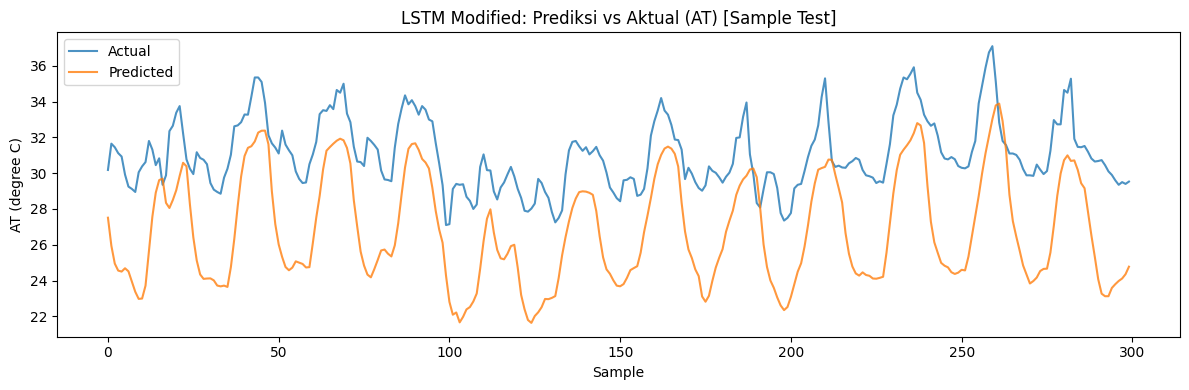

In [46]:
plt.figure(figsize=(12, 4))
plt.plot(y_test_true[:300], label='Actual', alpha=0.8)
plt.plot(y_pred_modif[:300], label='Predicted', alpha=0.8)
plt.title('LSTM Modified: Prediksi vs Aktual (AT) [Sample Test]')
plt.ylabel('AT (degree C)')
plt.xlabel('Sample')
plt.legend()
plt.tight_layout()
plt.show()


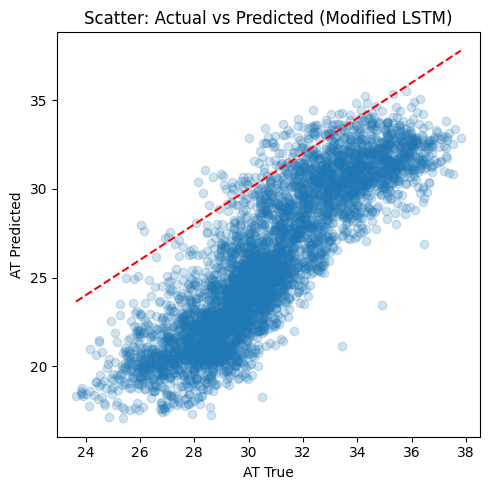

In [47]:
plt.figure(figsize=(5,5))
plt.scatter(y_test_true, y_pred_modif, alpha=0.2)
plt.xlabel('AT True')
plt.ylabel('AT Predicted')
plt.title('Scatter: Actual vs Predicted (Modified LSTM)')
plt.plot([y_test_true.min(), y_test_true.max()],
         [y_test_true.min(), y_test_true.max()], 'r--')  # Diagonal
plt.tight_layout()
plt.show()


#### Evaluasi Model LSTM Modifikasi

| Metric  | Test Set Value |
|---------|----------------|
| MAE     | 4.8864         |
| MSE     | 29.1163        |
| R²      | -3.0400        |

- **MAE (4.89) dan MSE (29.12)** lebih baik dibandingkan baseline (**MAE 5.62, MSE 36.84**), menunjukkan model modifikasi lebih mampu memprediksi suhu udara (AT), walaupun model masih meleset cukup jauh untuk ukuran suhu, blm akurat.
- **R² Score tetap negatif (-3.04)** namun membaik dibanding baseline (-4.11). Model belum mampu melakukan generalisasi dengan baik, tapi setidaknya ada peningkatan.
- **Training curve** (gap train/val loss) menunjukkan overfitting berkurang, val_loss lebih stabil daripada baseline.
- **Visualisasi prediksi vs aktual dan scatter plot**: Model modifikasi masih sering **underestimate**, tetapi lebih dekat ke pola aktual dibanding baseline.
- **Penyebaran prediksi** pada scatter plot lebih mengumpul di sekitar garis diagonal, walau masih belum optimal.

#### Perbandingan dengan Model Baseline

| Model         | MAE    | MSE     | R²      |
|---------------|--------|---------|---------|
| **Baseline**  | 5.6230 | 36.8447 | -4.1124 |
| **Modifikasi**| 4.8864 | 29.1163 | -3.0400 |

- **Model modifikasi lebih baik** pada semua metrik (MAE, MSE, R²).
- Modifikasi (2 LSTM layer + Dropout) meningkatkan kemampuan model dalam menangkap pola, sekaligus mengurangi dedikit overfitting.
- Namun, **kedua model masih kurang baik** (R² < 0), perlu eksplorasi lebih lanjut untuk meningkatkan generalisasi (tuning, arsitektur lain, dll).

**Next step:**
- Karena model **modifikasi lebih baik**, model ini yang akan digunakan untuk **hyperparameter tuning** pada tahap berikutnya untuk mencari kombinasi parameter terbaik.


## Hypertuning Best Model(Walaupun Jelek Banget):(((

## Search Space

In [48]:
param_grid = [
    {'units': 16, 'dropout': 0.2},
    {'units': 16, 'dropout': 0.3},
    {'units': 32, 'dropout': 0.2},
    {'units': 32, 'dropout': 0.3},
]


Alasan Pemilihan Parameter Grid (param_grid):
- units (16 & 32): Dipilih untuk membandingkan pengaruh ukuran hidden size terhadap performa model, umumnya cukup untuk dataset multivariat dengan jumlah fitur sedang, dan tidak terlalu besar sehingga tetap efisien secara komputasi dan baseline 10 kemungkinan terlalu kecil sepeeti yang kita coba diawal.
- dropout (0.2 & 0.3): Digunakan untuk mencegah overfitting, disini aku coba 0.2 dan 0.3 karenaumum untuk regularisasi ringan dan sedang tanpa membuat model belajar terlalu sedikit.

# Training & Evaluaton

In [49]:
results = []
for params in param_grid:
    # Build model
    model = Sequential([
        Input(shape=(n_timesteps, n_features)),
        LSTM(params['units'], return_sequences=True),
        Dropout(params['dropout']),
        LSTM(params['units']//2),
        Dropout(params['dropout']),
        Dense(1, activation='linear')
    ])
    model.compile(optimizer=Adam(), loss='mse', metrics=['mae'])

    # EarlyStopping callback
    early_stop = EarlyStopping(
        monitor='val_loss',
        patience=7,
        restore_best_weights=True,
        verbose=0
    )

    # Train
    history = model.fit(
        X_train_seq, y_train_seq,
        epochs=50,
        batch_size=64,
        validation_data=(X_val_seq, y_val_seq),
        callbacks=[early_stop],
        verbose=1
    )

    best_epoch = np.argmin(history.history['val_loss']) + 1

    # Predict
    y_pred = model.predict(X_test_seq)
    y_pred_inv = scaler_y.inverse_transform(y_pred)
    y_true_inv = scaler_y.inverse_transform(y_test_seq.reshape(-1, 1))

    # Metrics
    mae = mean_absolute_error(y_true_inv, y_pred_inv)
    mse = mean_squared_error(y_true_inv, y_pred_inv)
    r2 = r2_score(y_true_inv, y_pred_inv)

    results.append({
        'units': params['units'],
        'dropout': params['dropout'],
        'epochs_run': best_epoch,
        'val_loss': history.history['val_loss'][best_epoch-1],
        'test_MAE': mae,
        'test_MSE': mse,
        'test_R2': r2
    })

    print(f"Done: units={params['units']} | dropout={params['dropout']} | epochs={best_epoch} | MAE={mae:.4f} | MSE={mse:.4f} | R2={r2:.4f}")

Epoch 1/50
591/591 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - loss: 0.0363 - mae: 0.1424 - val_loss: 0.0140 - val_mae: 0.1001
Epoch 2/50
591/591 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 0.0105 - mae: 0.0809 - val_loss: 0.0103 - val_mae: 0.0846
Epoch 3/50
591/591 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - loss: 0.0070 - mae: 0.0660 - val_loss: 0.0093 - val_mae: 0.0818
Epoch 4/50
591/591 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - loss: 0.0055 - mae: 0.0582 - val_loss: 0.0080 - val_mae: 0.0766
Epoch 5/50
591/591 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - loss: 0.0047 - mae: 0.0540 - val_loss: 0.0075 - val_mae: 0.0751
Epoch 6/50
591/591 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - loss: 0.0042 - mae: 0.0508 - val_loss: 0.0074 - val_mae: 0.0754
Epoch 7/50
591/591 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - loss: 0.0039 - mae: 0.0493 - val_loss: 0.0079 - val_mae: 0.0780
Epoch 8/50
591/591 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - loss: 0.0038 - mae: 0.0480 - val_loss: 0.0089 - val_mae: 0.0830
Epoch 9/50
591/591 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/s

In [50]:
# Tampilkan hasil grid search
df_results = pd.DataFrame(results)
print(df_results.sort_values('test_MAE'))

   units  dropout  epochs_run  val_loss  test_MAE   test_MSE   test_R2
1     16      0.3           4  0.008013  4.725798  25.210231 -2.498050
2     32      0.2          12  0.008426  5.088928  30.697118 -3.259384
3     32      0.3           8  0.006241  5.125279  30.445218 -3.224431
0     16      0.2           6  0.007440  5.422176  33.077421 -3.589663


## Visualisasi untuk Model Terbaik Grid Search

In [56]:
df_results = pd.DataFrame(results)
best_idx = df_results['test_MAE'].idxmin()
best_params = param_grid[best_idx]
print("Best Params:", best_params)

# Training ulang model terbaik agar dapat history & prediksi untuk visualisasi
best_units = best_params['units']
best_dropout = best_params['dropout']

model_best = Sequential([
    Input(shape=(n_timesteps, n_features)),
    LSTM(best_units, return_sequences=True),
    Dropout(best_dropout),
    LSTM(best_units // 2),
    Dropout(best_dropout),
    Dense(1, activation='linear')
])
model_best.compile(optimizer=Adam(), loss='mse', metrics=['mae'])

early_stop = EarlyStopping(
    monitor='val_loss', patience=7, restore_best_weights=True, verbose=0
)

history_best = model_best.fit(
    X_train_seq, y_train_seq,
    epochs=50,
    batch_size=64,
    validation_data=(X_val_seq, y_val_seq),
    callbacks=[early_stop],
    verbose=1
)

y_pred_best = model_best.predict(X_test_seq)
y_pred_best_inv = scaler_y.inverse_transform(y_pred_best)
y_test_true_inv = scaler_y.inverse_transform(y_test_seq.reshape(-1, 1))


Best Params: {'units': 16, 'dropout': 0.3}
Epoch 1/50
591/591 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - loss: 0.0539 - mae: 0.1741 - val_loss: 0.0163 - val_mae: 0.1081
Epoch 2/50
591/591 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - loss: 0.0127 - mae: 0.0891 - val_loss: 0.0132 - val_mae: 0.0967
Epoch 3/50
591/591 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - loss: 0.0078 - mae: 0.0695 - val_loss: 0.0113 - val_mae: 0.0909
Epoch 4/50
591/591 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - loss: 0.0057 - mae: 0.0597 - val_loss: 0.0088 - val_mae: 0.0809
Epoch 5/50
591/591 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - loss: 0.0049 - mae: 0.0553 - val_loss: 0.0080 - val_mae: 0.0774
Epoch 6/50
591/591 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - loss: 0.0046 - mae: 0.0531 - val_loss: 0.0090 - val_mae: 0.0832
Epoch 7/50
591/591 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - loss: 0.0043 - mae: 0.0513 - val_loss: 0.0082 - val_mae: 0.0792
Epoch 8/50
591/591 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - loss: 0.0041 - mae: 0.0498 - val_loss: 0.0080 - val_mae: 0.0780
Epoch 

## Plot Visualisasi Grid Search Model Terbaik

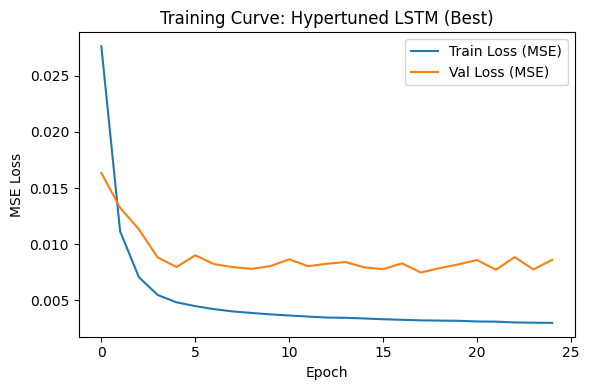

In [57]:
plt.figure(figsize=(6, 4))
plt.plot(history_best.history['loss'], label='Train Loss (MSE)')
plt.plot(history_best.history['val_loss'], label='Val Loss (MSE)')
plt.title('Training Curve: Hypertuned LSTM (Best)')
plt.ylabel('MSE Loss')
plt.xlabel('Epoch')
plt.legend()
plt.tight_layout()
plt.show()

## Prediksi vs Aktual (Sample Test)

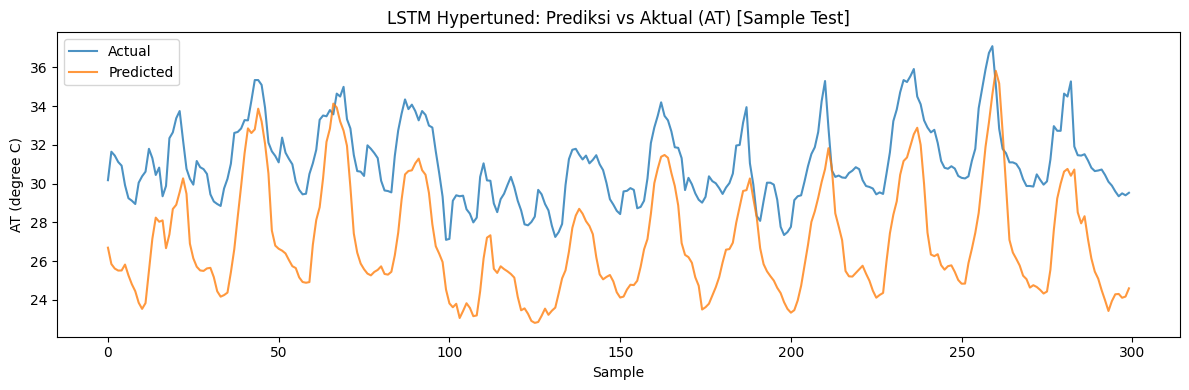

In [58]:
plt.figure(figsize=(12, 4))
plt.plot(y_test_true_inv[:300], label='Actual', alpha=0.8)
plt.plot(y_pred_best_inv[:300], label='Predicted', alpha=0.8)
plt.title('LSTM Hypertuned: Prediksi vs Aktual (AT) [Sample Test]')
plt.ylabel('AT (degree C)')
plt.xlabel('Sample')
plt.legend()
plt.tight_layout()
plt.show()

## Scatter Plot



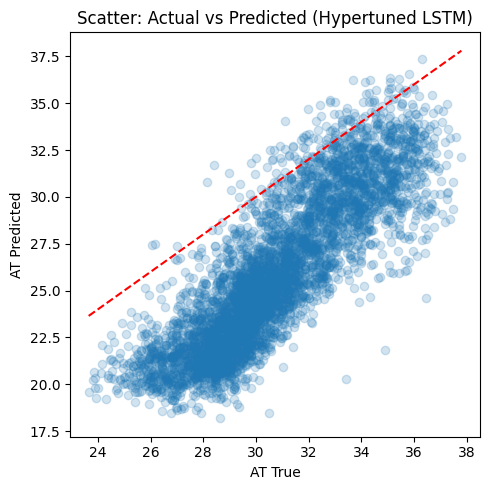

In [59]:
plt.figure(figsize=(5, 5))
plt.scatter(y_test_true_inv, y_pred_best_inv, alpha=0.2)
plt.xlabel('AT True')
plt.ylabel('AT Predicted')
plt.title('Scatter: Actual vs Predicted (Hypertuned LSTM)')
plt.plot(
    [y_test_true_inv.min(), y_test_true_inv.max()],
    [y_test_true_inv.min(), y_test_true_inv.max()],
    'r--'
)
plt.tight_layout()
plt.show()


## Evaluasi Akhir (Model Terbasik dari Hypertune)

#### Evaluasi Model LSTM Hypertuned

| Metric  | Test Set Value |
|---------|----------------|
| MAE     | 4.7258         |
| MSE     | 25.2102        |
| R²      | -2.4981        |

- **MAE (4.73) dan MSE (25.21)** pada model hypertuned menunjukkan adanya **peningkatan akurasi** dibanding baseline (**MAE 5.62, MSE 36.84**) maupun modifikasi (**MAE 4.89, MSE 29.12**), tapi error masih tetap besar, tidak akurat
- **R² Score tetap negatif (-2.50)**, namun nilainya **semakin mendekati 0**, artinya model sudah lebih baik dalam menangkap pola, meskipun generalisasi belum sempurna, dan model masih kesulitas belajar.
- **Training curve** pada hypertuned LSTM menunjukkan loss yang menurun stabil dengan val_loss yang relatif tidak meningkat drastis, menandakan overfitting berkuarang setidaknya:)))
- **Visualisasi prediksi vs aktual**: Model hypertuned mulai lebih mengikuti pola fluktuasi suhu udara aktual.
- **Scatter plot**: Prediksi model lebih mendekati garis diagonal dibanding baseline/modifikasi, meski tetap saja penyebaran prediksi belum sepenuhnya rapat di sekitar garis ideal.
- Model hypertuned lebih robust dan memiliki *generalization error* yang lebih rendah dibanding baseline maupun modifikasi.

#### Perbandingan dengan Model Baseline & Modifikasi

| Model         | MAE    | MSE     | R²      |
|---------------|--------|---------|---------|
| Baseline      | 5.6230 | 36.8447 | -4.1124 |
| Modifikasi    | 4.8864 | 29.1163 | -3.0400 |
| Hypertuned    | 4.7258 | 25.2102 | -2.4981 |


**Kesimpulan:**
- **Hypertuned LSTM** dengan `units=16, dropout=0.3` menjadi model terbaik pada percobaan ini dan digunakan sebagai model akhir untuk prediksi suhu udara (AT).
- Untuk kedepannya(kalau ga time constraint kayak sekarang) perlu eksplorasi lanjutan untuk memperbaiki generalisasi, seperti feature engineering tambahan seperti membuat fitur waktu baru (misal: sin/cos transformasi jam, hari, bulan), menggunakan lag features (fitur historis lebih panjang) atau rolling window statistics (mean, std, dll). untuk membantu model menangkap pola musiman/harian., arsitektur lain (bidirectional LSTM, attention), atau tuning lebih lanjutm misalnya coba algoritma optimasi lain (misal, AdamW, RMSprop), cross-validation berbasis waktu agar evaluasi lebih reliabel, grid search lebih banyak lagi, atau dengan Preprocessing Advanced advance seperti VIT  atau SHAP/Permutation Importance untuk memilih fitur paling berpengaruh, sehingga hanya fitur penting yang digunakan—dapat meningkatkan interpretabilitas dan menurunkan noise input ke model atau **Principal Component Analysis (PCA):** Untuk mereduksi dimensi dan menangkap informasi paling penting.


### Bonus: Apakah Problem Ini Bisa Menggunakan Time Series Multivariate?

Ya, problem prediksi kualitas udara ini **sangat mungkin dan memang ideal** untuk menggunakan time series multivariate.

#### Alasannya ???
- **Time series multivariate** adalah pemodelan deret waktu yang menggunakan lebih dari satu variabel input pada setiap titik waktu (timestamp) untuk memprediksi target di masa mendatang. Pada kasus kali ini, setiap timestamp tidak hanya memiliki nilai target (AT), tetapi juga banyak fitur pengukuran lain seperti konsentrasi polutan udara (PM2.5, PM10, NO, NO2, CO, dll), cuaca (suhu, kelembapan, tekanan udara, dsb), dan informasi waktu, artiinya, target prediksi pada waktu tertentu (AT di masa depan) **tidak hanya dipengaruhi oleh nilai masa lalu AT itu sendiri**, melainkan juga oleh fitur-fitur lain yang saling berkaitan di waktu yang sama atau berbeda

#### Indentifikasi apakah suatu pronlem adalah time series multivariate?
- Problem time series bisa disebut multivariate jika **setiap timestamp memiliki lebih dari satu variabel prediktor** (kolom selain waktu dan target).Ciri lainmya terdapat **hubungan atau pengaruh logis antar fitur**, misalnya polutan dan cuaca sama-sama memengaruhi AT, sehingga memasukkan semua sebagai input dapat meningkatkan prediksi. Pada kasus ini, **analisis korelasi** juga menunjukkan adanya hubungan antara fitur-fitur tersebut terhadap target, sehingga multivariate lebih informatif dibanding univariate.

Dalam kasus ini, dengan memasukkan semua fitur numerik (polutan, cuaca, dsb) sebagai input, model bisa belajar hubungan kompleks antar fitur dan waktu, hal ini dapat **meningkatkan akurasi prediksi**, karena model memanfaatkan seluruh informasi yang tersedia dan saling memengaruhi di lingkungan kualitas udara.


Jujur pak, jadwal kali ini bahkan lebih hectic dibangdingkan UAS, di hari Senin ada 2 ujian teori yang banyak, disaat yang bersamaan harus menyelesaikan Deep Learning dan Model Deployemnt, jadi total aku kayak ngelatih 4 model dalam waktu 7 hari:((((, maaf jadinya pak kalau blm bisa maksimal

Link Video Penjelasan: https://drive.google.com/drive/folders/141OlnArdQKAYOp8kLUJ5PT-dQ-1dhP79?usp=sharing